### Get dataset

In [1]:
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"peter1325","key":"adbb4ce8a4f600f471b2369b672eabcf"}

import json
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 58 kB 387 kB/s eta 0:00:01
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=a67d51257a79ef32da73bb887988dc26cf7d6653373c609e8aca1804154a4f04
  Stored in directory: /tmp/pip-ephem-wheel-cache-z95is4w8/wheels/29/da/11/144cc25aebdaeb4931b231e25fd34b394e6a5725cbb2f50106
Successfully built kaggle
 99%|███████████████████████████████████████▌| 705M/714M [00:23<00:00, 32.4MB/s]
100%|████████████████████████████████████████| 714M/714M [00:24<00:00, 31.2MB/s]


In [2]:
!pip install opencv-python
#apt-get update && apt-get install -y python3-opencv
#pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 60.9 MB 35.3 MB/s eta 0:00:01


In [1]:
import os
import glob
import random
import cv2
from PIL import Image
import numpy as np
import copy
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import make_grid
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import albumentations as A
'''deepmets'''
from deepmets.backbone import *
from deepmets.head import *
'''UTNet'''
from UTNet.unet_utils import up_block, down_block
from UTNet.conv_trans_utils import *
from UTNet.utnet import UTNet, UTNet_Encoderonly
'''Efficient-Unet'''
from EfficientUnet.efficientunet import *

/home/peterstat1325/anaconda3/envs/fedseg/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [3]:
def set_seed(seed = 1000):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    
set_seed()

## Load files

In [4]:
ROOT_PATH = '../Shared/Pin-Han/kaggle_3m/'

mask_files = glob.glob(ROOT_PATH + '*/*_mask*')
image_files = [file.replace('_mask', '') for file in mask_files]

def diagnosis(mask_path):
    return 1 if np.max(cv2.imread(mask_path)) > 0 else 0

files_df = pd.DataFrame({"image_path": image_files,
                  "mask_path": mask_files,
                  "diagnosis": [diagnosis(x) for x in mask_files]})

files_df

,image_path,mask_path,diagnosis
0,../Shared/Pin-Han/kaggle_3m/TCGA_DU_6405_19851...,../Shared/Pin-Han/kaggle_3m/TCGA_DU_6405_19851...,0
1,../Shared/Pin-Han/kaggle_3m/TCGA_DU_6405_19851...,../Shared/Pin-Han/kaggle_3m/TCGA_DU_6405_19851...,0
2,../Shared/Pin-Han/kaggle_3m/TCGA_DU_6405_19851...,../Shared/Pin-Han/kaggle_3m/TCGA_DU_6405_19851...,0
3,../Shared/Pin-Han/kaggle_3m/TCGA_DU_6405_19851...,../Shared/Pin-Han/kaggle_3m/TCGA_DU_6405_19851...,0
4,../Shared/Pin-Han/kaggle_3m/TCGA_DU_6405_19851...,../Shared/Pin-Han/kaggle_3m/TCGA_DU_6405_19851...,0
...,...,...,...
3924,../Shared/Pin-Han/kaggle_3m/TCGA_HT_7860_19960...,../Shared/Pin-Han/kaggle_3m/TCGA_HT_7860_19960...,0
3925,../Shared/Pin-Han/kaggle_3m/TCGA_HT_7860_19960...,../Shared/Pin-Han/kaggle_3m/TCGA_HT_7860_19960...,0
3926,../Shared/Pin-Han/kaggle_3m/TCGA_HT_7860_19960...,../Shared/Pin-Han/kaggle_3m/TCGA_HT_7860_19960...,0
3927,../Shared/Pin-Han/kaggle_3m/TCGA_HT_7860_19960...,../Shared/Pin-Han/kaggle_3m/TCGA_HT_7860_19960...,1


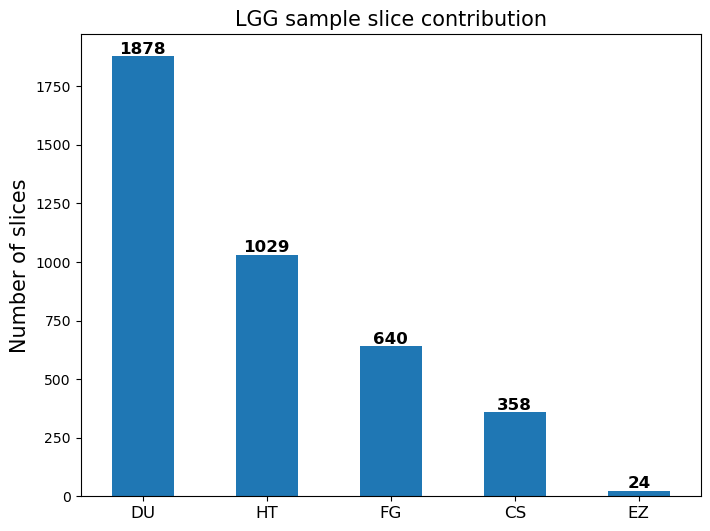

In [5]:
site = pd.Series([path.split('/')[-1].split('_')[1] for path in files_df['image_path']])
ax_s = site.value_counts().plot(kind='bar', stacked=True, figsize=(8,6))
ax_s.set_title('LGG sample slice contribution', fontsize=15)
ax_s.set_ylabel('Number of slices', fontsize=15)
ax_s.set_xticklabels(['DU', 'HT', 'FG', 'CS', 'EZ'], fontsize=12, rotation=0)
for i, rows in enumerate(site.value_counts().values):
    ax_s.annotate(int(rows), xy=(i, rows+12), ha='center', fontweight='bold', fontsize=12)

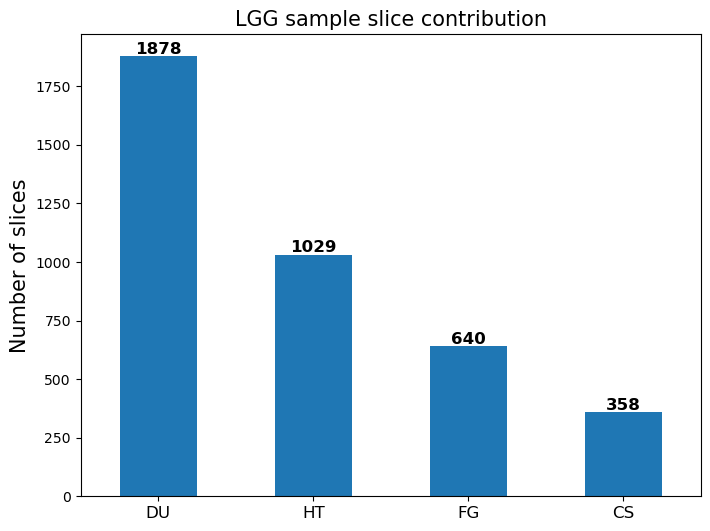

In [36]:
site = pd.Series([path.split('/')[-1].split('_')[1] for path in files_df['image_path']])
ax_s = site.value_counts()[:-1].plot(kind='bar', stacked=True, figsize=(8,6))
ax_s.set_title('LGG sample slice contribution', fontsize=15)
ax_s.set_ylabel('Number of slices', fontsize=15)
ax_s.set_xticklabels(['DU', 'HT', 'FG', 'CS'], fontsize=12, rotation=0)
for i, rows in enumerate(site.value_counts().values):
    ax_s.annotate(int(rows), xy=(i, rows+12), ha='center', fontweight='bold', fontsize=12)

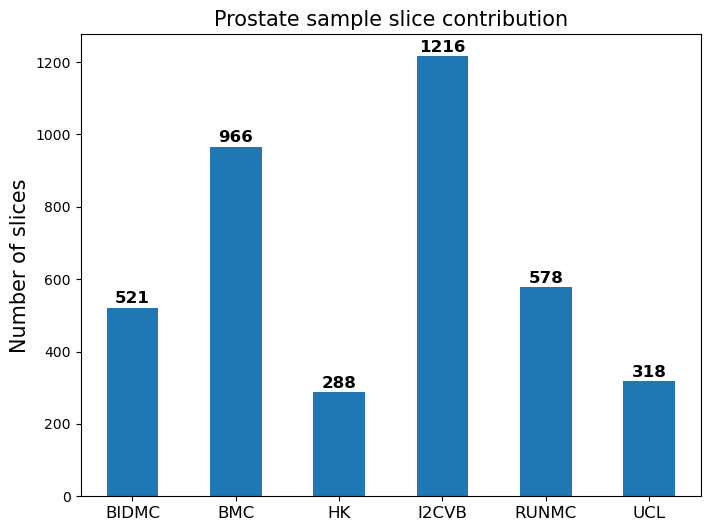

In [37]:
pros = [521, 966, 288, 1216, 578, 318]
site_p = pd.Series(['BIDMC']*pros[0]+['BMC']*pros[1]+['HK']*pros[2]+['I2CVB']*pros[3]+['RUNMC']*pros[4]+['UCL']*pros[5])
ax_p = site_p.value_counts().sort_index().plot(kind='bar', stacked=True, figsize=(8,6))
ax_p.set_title('Prostate sample slice contribution', fontsize=15)
ax_p.set_ylabel('Number of slices', fontsize=15)
ax_p.set_xticklabels(['BIDMC', 'BMC', 'HK', 'I2CVB', 'RUNMC', 'UCL'], fontsize=12, rotation=0)
for i, rows in enumerate(site_p.value_counts().sort_index().values):
    ax_p.annotate(int(rows), xy=(i, rows+12), ha='center', fontweight='bold', fontsize=12)

## About data distribution

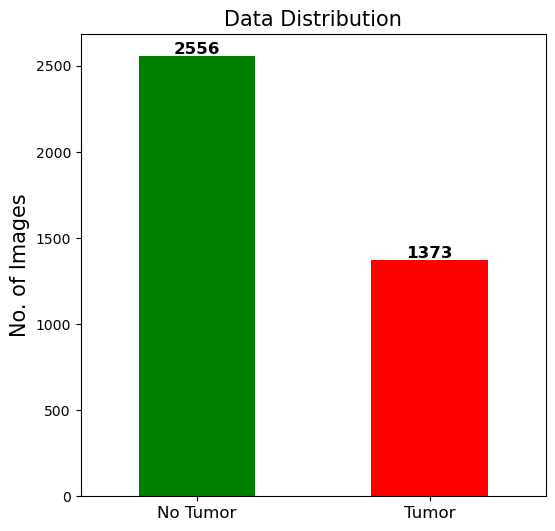

In [5]:
ax = files_df['diagnosis'].value_counts().plot(kind='bar', stacked=True, figsize=(6,6), color=['green', 'red'])
ax.set_title('Data Distribution', fontsize=15)
ax.set_ylabel('No. of Images', fontsize=15)
ax.set_xticklabels(['No Tumor', 'Tumor'], fontsize=12, rotation=0)
for i, rows in enumerate(files_df['diagnosis'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows+12), ha='center', fontweight='bold', fontsize=12)

## train/test split

In [5]:
train_df, val_df = train_test_split(files_df, stratify=files_df['diagnosis'], test_size=0.1, random_state=0)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_df, test_df = train_test_split(train_df, stratify=train_df['diagnosis'], test_size=0.15, random_state=0)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("Train: {}\nVal: {}\nTest: {}".format(train_df.shape, val_df.shape, test_df.shape))

Train: (3005, 3)
Val: (393, 3)
Test: (531, 3)


In [7]:
train_df

,image_path,mask_path,diagnosis
0,./lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_...,./lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_...,0
1,./lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_...,./lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_...,0
2,./lgg-mri-segmentation/kaggle_3m/TCGA_DU_6400_...,./lgg-mri-segmentation/kaggle_3m/TCGA_DU_6400_...,1
3,./lgg-mri-segmentation/kaggle_3m/TCGA_CS_5397_...,./lgg-mri-segmentation/kaggle_3m/TCGA_CS_5397_...,0
4,./lgg-mri-segmentation/kaggle_3m/TCGA_DU_7302_...,./lgg-mri-segmentation/kaggle_3m/TCGA_DU_7302_...,0
...,...,...,...
3000,./lgg-mri-segmentation/kaggle_3m/TCGA_HT_A5RC_...,./lgg-mri-segmentation/kaggle_3m/TCGA_HT_A5RC_...,0
3001,./lgg-mri-segmentation/kaggle_3m/TCGA_DU_8167_...,./lgg-mri-segmentation/kaggle_3m/TCGA_DU_8167_...,0
3002,./lgg-mri-segmentation/kaggle_3m/TCGA_CS_6668_...,./lgg-mri-segmentation/kaggle_3m/TCGA_CS_6668_...,1
3003,./lgg-mri-segmentation/kaggle_3m/TCGA_HT_7473_...,./lgg-mri-segmentation/kaggle_3m/TCGA_HT_7473_...,0


## View the dataset

(-0.5, 2047.5, 255.5, -0.5)

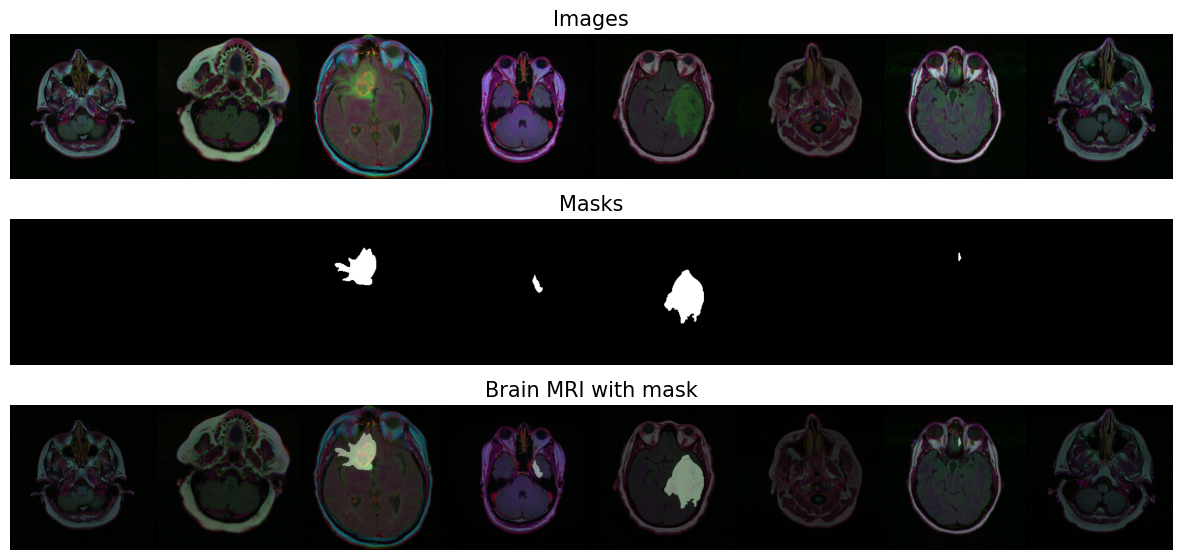

In [14]:
set_seed()

images, masks = [], []
df_positive = train_df[train_df['diagnosis']==1].sample(8).values

#df_positive = train_df.sample(8).values

for sample in df_positive:
    img = cv2.imread(sample[0])
    mask = cv2.imread(sample[1])
    images.append(img)
    masks.append(mask)
images = np.hstack(np.array(images))
masks = np.hstack(np.array(masks))

fig = plt.figure(figsize=(15,10))
grid = ImageGrid(fig, 111, nrows_ncols=(3,1), axes_pad=0.4)

grid[0].imshow(images)
grid[0].set_title('Images', fontsize=15)
grid[0].axis('off')
grid[1].imshow(masks)
grid[1].set_title('Masks', fontsize=15)
grid[1].axis('off')
grid[2].imshow(images)
grid[2].imshow(masks, alpha=0.4)
grid[2].set_title('Brain MRI with mask', fontsize=15)
grid[2].axis('off')

## Convert to Pytorch dataset format

In [6]:
class BrainDataset(data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 0])
        image = (np.array(image)/255.)#.astype(np.uint8)
        mask = cv2.imread(self.df.iloc[idx, 1], 0)
        #mean_img = np.expand_dims(np.mean(image, axis = 2), axis = -1)
        #image = np.concatenate((mean_img, mean_img, mean_img), axis=2)
        mask = (np.array(mask)/255.)#.astype(np.uint8)
            
        if self.transform is not None:
            aug = self.transform(image=image, mask=mask)
            image = aug['image']
            mask = aug['mask']

        image = image.transpose((2,0,1))
        image = torch.from_numpy(image).type(torch.float32)
        image = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image)
        mask = np.expand_dims(mask, axis=-1).transpose((2,0,1))
        mask = torch.from_numpy(mask).type(torch.float32)
        
        return image, mask

In [7]:
train_tfm = A.Compose([
    A.Resize(width=256, height=256, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    #A.transforms.Equalize(p=1),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
])

val_tfm = A.Compose([
    A.Resize(width=256, height=256, p=1.0),
    A.Transpose(p=0.5),
    #A.transforms.Equalize(p=1),
    A.HorizontalFlip(p=0.5),
])

test_tfm = A.Compose([
    A.Resize(width=256, height=256, p=1),
    #A.transforms.Equalize(p=1),
])

## Construct dataset

In [8]:
set_seed()

train_ds = BrainDataset(train_df, train_tfm)
val_ds = BrainDataset(val_df, val_tfm)
test_ds = BrainDataset(test_df, test_tfm)

In [12]:
def dataset_info(dataset): 
    print(f'Size of dataset: {len(dataset)}')
    index = random.randint(1, 40)
    img, label = dataset[index]
    print(f'Sample-{index} Image size: {img.shape}, Mask: {label.shape}\n')

In [13]:
print('Train dataset:')
dataset_info(train_ds)
print('Validation dataset:')
dataset_info(val_ds)
print('Test dataset:')
dataset_info(test_ds)

Train dataset:
Size of dataset: 3005
Sample-28 Image size: torch.Size([3, 256, 256]), Mask: torch.Size([1, 256, 256])

Validation dataset:
Size of dataset: 393
Sample-24 Image size: torch.Size([3, 256, 256]), Mask: torch.Size([1, 256, 256])

Test dataset:
Size of dataset: 531
Sample-32 Image size: torch.Size([3, 256, 256]), Mask: torch.Size([1, 256, 256])



## Define Dice loss and BCE loss and IOU

In [9]:
def dice_coef_metric(pred, label):
    intersection = 2.0 * (pred * label).sum()
    union = pred.sum() + label.sum()
    if (pred.sum() == 0) and (label.sum() == 0):
        return 1.
    return intersection / union

def iou_metric(pred, label):
    intersection = np.sum(pred * label)
    union = np.sum(pred) + np.sum(label) - intersection
    if (np.sum(pred) == 0) and (np.sum(label) == 0):
        return 1 
    return intersection / union

def gamma_dice_loss(pred, label, gamma=1e-4):
    '''
    gamma selection: positive number, min: 1e-6
    '''
    pos = torch.sigmoid((1+gamma)*pred)
    neg = 1 - pos
    power = gamma/(1+gamma)
    #gamma_loss = (1/gamma)*torch.mean(label*(1-(pos**power)) + (1-label)*(1-(neg**power)))
    score = label*((1-(pos**power))/gamma) + (1-label)*((1-(neg**power))/gamma)
    '''gamma selection for this batch, used for computing mean gamma for next FL round'''
    gam_update = gam_logit_select(score, pred, label)
    gamma_loss = torch.mean(score)
    dice_loss = dice_coef_loss(pred, label)
    tot_loss = gamma_loss + dice_loss
    return tot_loss, gam_update

def dice_coef_loss(pred, label):
    smooth = 1.0
    intersection = 2.0 * (pred * label).sum() + smooth
    union = pred.sum() + label.sum() + smooth
    return 1 - (intersection / union)

def bce_dice_loss(pred, label):
    dice_loss = dice_coef_loss(pred, label)
    bce_loss = nn.BCELoss()(pred, label)
    #bce_loss = nn.BCEWithLogitsLoss()(pred, label)
    return dice_loss + bce_loss

def combo_loss(pred, label, alpha=0.8):
    dice_loss = dice_coef_loss(pred, label)
    bce_loss = nn.BCELoss()(pred, label)
    #bce_loss = nn.BCEWithLogitsLoss()(pred, label)
    return alpha*bce_loss + (1-alpha)*dice_loss

def mse_loss(pred, label):
    return nn.MSELoss()(pred,label)

def mse_dice_loss(pred, label):
    dice_loss = dice_coef_loss(pred, label)
    mse_loss = nn.MSELoss()(pred, label)
    #bce_loss = nn.BCEWithLogitsLoss()(pred, label)
    return dice_loss + mse_loss

#focal loss: let the model not pass sigmoid layer
def focal_loss(pred, label):
    #focal loss
    focal_loss = torchvision.ops.sigmoid_focal_loss(pred, label, alpha=0.75, gamma=2, reduction = 'mean')
    return focal_loss

def focal_dice_loss(pred, label):
    dice_loss = dice_coef_loss(pred, label)
    focal_loss = torchvision.ops.sigmoid_focal_loss(pred, label, alpha=0.75, gamma=0.5, reduction='mean')
    return dice_loss + focal_loss

'''
About Unified Focal Loss
'''

def identify_axis(shape):
    # Three dimensional
    if len(shape) == 5 : return [2,3,4]
    # Two dimensional
    elif len(shape) == 4 : return [2,3]
    # Exception - Unknown
    else : raise ValueError('Metric: Shape of tensor is neither 2D or 3D.')

def sym_unified_focal_loss(y_pred, y_true, weight=0.5, delta=0.6, gamma=0.5):

    symmetric_ftl = symmetric_focal_tversky_loss(y_pred, y_true, delta=delta, gamma=gamma)
    symmetric_fl = symmetric_focal_loss(y_pred, y_true, delta=delta, gamma=gamma)
    if weight is not None:
        return (weight * symmetric_ftl) + ((1-weight) * symmetric_fl)  
    else:
        return symmetric_ftl + symmetric_fl


def symmetric_focal_tversky_loss(y_pred, y_true, delta=0.7, gamma=0.75):

    # Clip values to prevent division by zero error
    epsilon =1e-7 #epsilon 
    y_pred = torch.clamp(y_pred, epsilon, 1. - epsilon)

    axis = identify_axis(y_true.size())
    # Calculate true positives (tp), false negatives (fn) and false positives (fp)
    
    tp = torch.sum(y_true * y_pred, dim=axis)
    fn = torch.sum(y_true * (1-y_pred), dim=axis)
    fp = torch.sum((1-y_true) * y_pred, dim=axis)

    dice_class = (tp + epsilon)/(tp + delta*fn + (1-delta)*fp + epsilon)
    #calculate losses separately for each class, enhancing both classes
    back_dice = (dice_class[:,0]) * torch.pow(dice_class[:,0], -gamma) 
    #fore_dice = (1-dice_class[:,1]) * torch.pow(1-dice_class[:,1], -gamma) 
    fore_dice = (1-dice_class[:,0]) * torch.pow(1-dice_class[:,0], -gamma) 
    
    # Average class scores
    loss = torch.mean(torch.stack([back_dice,fore_dice], dim=-1))
    return loss


def symmetric_focal_loss(y_pred, y_true, delta=0.7, gamma=2.):

    axis = identify_axis(y_true.size())  

    epsilon =1e-7 
    y_pred = torch.clamp(y_pred, epsilon, 1. - epsilon)
    cross_entropy = nn.BCELoss()(y_pred, y_true) #-y_true * torch.log(y_pred)
    #calculate losses separately for each class
    #back_ce = torch.pow(1 - y_pred[:,0,:,:], gamma) * cross_entropy[:,0,:,:]
    back_ce = torch.pow(y_pred[:,0,:,:], gamma) * (1-cross_entropy) #[:,0,:,:]
    back_ce =  (1 - delta) * back_ce

    #fore_ce = torch.pow(1 - y_pred[:,:,:,1], gamma) * cross_entropy[:,:,:,1]
    #fore_ce = torch.pow(y_pred[:,0,:,:], gamma) * (1-cross_entropy[:,0,:,:])
    fore_ce = torch.pow(1-y_pred[:,0,:,:], gamma) * (cross_entropy) #[:,0,:,:]
    fore_ce = delta * fore_ce

    loss = torch.mean(torch.sum(torch.stack([back_ce, fore_ce],dim=-1),dim=-1))

    return loss


def tversky_loss(y_pred, y_true, delta = 0.6, smooth = 0.000001):
    axis = identify_axis(y_true.size())
    # Calculate true positives (tp), false negatives (fn) and false positives (fp)
    '''
    tp = torch.sum(y_true * y_pred, dim=axis)
    fn = torch.sum(y_true * (1-y_pred), dim=axis)
    fp = torch.sum((1-y_true) * y_pred, dim=axis)
    '''
    
    tp = (y_pred*y_true).sum()
    fn = ((1-y_pred)*y_true).sum()
    fp = (y_pred*(1-y_true)).sum()
    
    
    tversky_class = (tp + smooth)/(tp + delta*fn + (1-delta)*fp + smooth)
    # Average class scores
    tversky_loss = torch.mean(1-tversky_class)

    return tversky_loss

## gamma selection

In [10]:
def gam_logit_select(points, pred, label, rho=0.5):
    #points shape: (batch_size, 1, 256, 256)
    eps = 1e-5
    #points, pred, label = points.data.cpu().numpy(), pred.data.cpu().numpy(), label.data.cpu().numpy()
    '''get median position index'''
    slice_points = torch.mean(points.reshape((points.shape[0],-1)), axis=-1) #(16, 256x256)
    med_idx = torch.argsort(slice_points)[len(slice_points)//2] #median index
    #print(pred.shape, med_idx)
    '''compute pos and neg'''
    logit = torch.sigmoid(pred[med_idx]) #compute logit for median
    '''compute positive and negative'''
    #pos = (1-rho)*torch.log(logit) #(rho-1)*(-1)
    pos = (rho-1)/(torch.log(logit)+eps)
    #neg = -(1-rho)*torch.log(1+torch.exp(pred[med_idx]))#(rho-1)
    neg = (1-rho)/(torch.log(1+torch.exp(pred[med_idx]))+eps)
    
    gamma = torch.mean(label[med_idx]*pos+(1-label[med_idx])*neg) #argmax to argmin, add minus
    gam_clip = torch.clamp(gamma, 1e-4, 1).data.cpu().numpy()
    return gam_clip

## Configuration (change setting here!)

In [11]:
config = {
    'n_epochs': 150, #50
    'batch_size': 64, #64
    'learning_rate': 5e-4, #5e-4, #1e-3
    'early_stop': 150,
    'model_name': 'effunet', #change model name: 'unet', 'resnext_unet', 'deepmets'
    'loss': gamma_dice_loss, #change loss function
    'loss_name': 'gamma_dice_loss', #change loss function name for saving file
    'gamma': 1e-4, #gamma>0, gamma_dice_loss, gamma=0, bce_dice_loss
    'mislabel_rate': 0, #0, 0.4, 0.6
    'n_worker': 4, #if not enough memory or model is large, set to 0 
}
save_path = 'brain-mri-'+config['model_name']+'_'+config['loss_name']+'_cln_0425.pth'
print('save_path:', save_path)

save_path: brain-mri-effunet_gamma_dice_loss_cln_0425.pth


## Get Dataloader

In [12]:
set_seed()
train_dl = DataLoader(train_ds, config['batch_size'], shuffle=True, num_workers=config['n_worker'], pin_memory=True)  
val_dl = DataLoader(val_ds, config['batch_size'], num_workers=config['n_worker'], pin_memory=True)
test_dl = DataLoader(val_ds, config['batch_size'], num_workers=config['n_worker'], pin_memory=True)

## Viewing sample from a batch

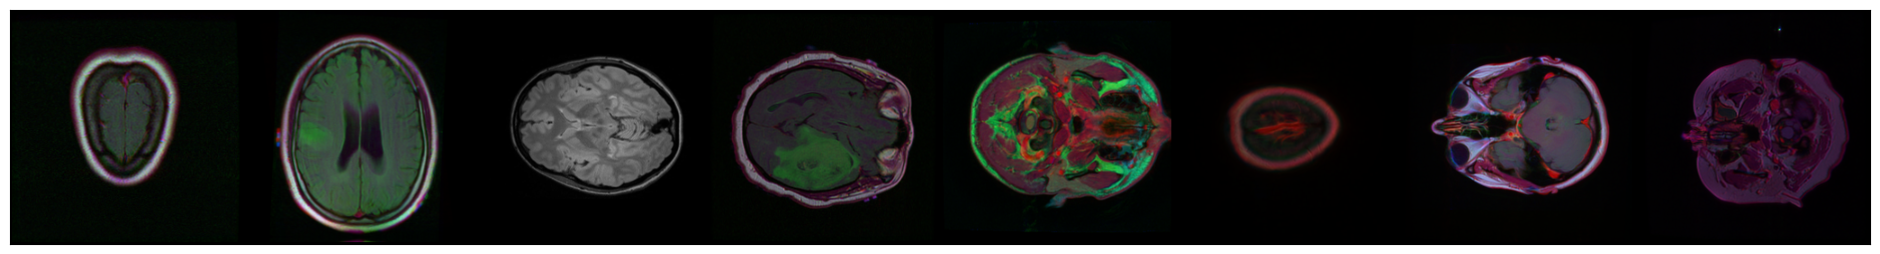

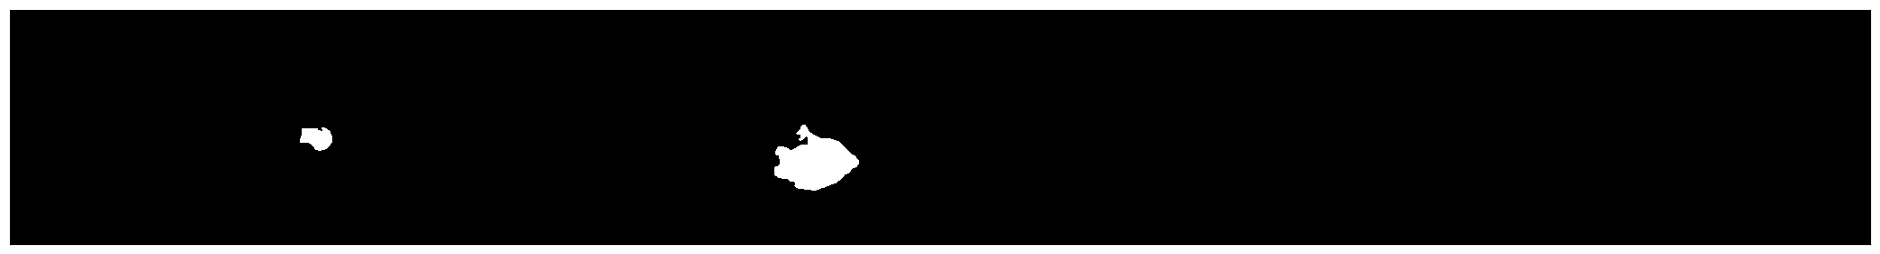

In [15]:
def denormalize(images):
    means = torch.tensor([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1)
    stds = torch.tensor([0.229, 0.224, 0.225]).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, masks in dl:
        fig1, ax1 = plt.subplots(figsize=(24, 24))
        ax1.set_xticks([]); ax1.set_yticks([])
        denorm_images = denormalize(images)
        ax1.imshow(make_grid(denorm_images[:8], nrow=8).permute(1, 2, 0).clamp(0,1))
        
        fig2, ax2 = plt.subplots(figsize=(24, 24))
        ax2.set_xticks([]); ax2.set_yticks([])
        ax2.imshow(make_grid(masks[:8], nrow=8).permute(1, 2, 0).clamp(0,1))
        break
        
show_batch(train_dl)

## U-net model

In [12]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True))
    def forward(self, x):
        return self.double_conv(x)
    
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels))
    def forward(self, x):
        return self.maxpool_conv(x)
    
class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels//2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        x1 = F.pad(x1, [diffX//2, diffX-diffX//2,
                        diffY//2, diffY-diffY//2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Sigmoid())
    def forward(self, x):
        return self.conv(x)

In [14]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.inc = DoubleConv(n_channels, 32) #64, 128, 256, 512
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        factor = 2 if bilinear else 1
        self.down4 = Down(256, 512//factor)
        self.up1 = Up(512, 256//factor, bilinear)
        self.up2 = Up(256, 128//factor, bilinear)        
        self.up3 = Up(128, 64//factor, bilinear)        
        self.up4 = Up(64, 32, bilinear)        
        self.outc = OutConv(32, n_classes)
    
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

## Model Selection

In [13]:
if config['model_name'] == 'unet':
    model = UNet(3, 1).to(device)
if config['model_name'] == 'resnext_unet':
    model = ResNeXtUNet(n_classes=1).to(device)
if config['model_name'] == 'deepmets':
    model = Model().to(device)
if config['model_name'] == 'utnet':
    model = UTNet(in_chan=3, base_chan=16, num_classes=1, reduce_size=8, #base_chan=32
                  block_list='1234', num_blocks=[1,1,1,1], num_heads=[2,2,2,2], #4
                  projection='interp', attn_drop=0.1, proj_drop=0.1, rel_pos=True, aux_loss=False, maxpool=True).to(device)
if config['model_name'] == 'effunet':
    model = efficientunet.get_efficientunet_b0(out_channels=1, concat_input=True, pretrained=True).to(device)
#print model output shape
#out = model(torch.randn(1, 3, 256, 256).to(device))
#print(out)

In [13]:
model

EfficientUnet(
  (encoder): Encoder(
    (stem_conv): Conv2dSamePadding(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (stem_batch_norm): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (stem_swish): Swish()
    (blocks): ModuleList(
      (0): MBConvBlock(
        (swish): Swish()
        (_depthwise_conv): Conv2dSamePadding(32, 32, kernel_size=(3, 3), stride=(1, 1), groups=32, bias=False)
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dSamePadding(32, 8, kernel_size=(1, 1), stride=(1, 1))
        (_se_expand): Conv2dSamePadding(8, 32, kernel_size=(1, 1), stride=(1, 1))
        (_project_conv): Conv2dSamePadding(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (_bn2): BatchNorm2d(16, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      )
      (1): MBConvBlock(
        (swish): Swish

In [14]:
from torchsummary import summary

In [16]:
summary(model, (3,256, 256))

Layer (type:depth-idx)                        Output Shape              Param #
├─Encoder: 1-1                                [-1, 1280, 8, 8]          --
|    └─Conv2dSamePadding: 2-1                 [-1, 32, 128, 128]        864
|    └─BatchNorm2d: 2-2                       [-1, 32, 128, 128]        64
|    └─Swish: 2-3                             [-1, 32, 128, 128]        --
|    └─ModuleList: 2                          []                        --
|    |    └─MBConvBlock: 3-1                  [-1, 16, 128, 128]        1,448
|    |    └─MBConvBlock: 3-2                  [-1, 24, 64, 64]          6,004
|    |    └─MBConvBlock: 3-3                  [-1, 24, 64, 64]          10,710
|    |    └─MBConvBlock: 3-4                  [-1, 40, 32, 32]          15,350
|    |    └─MBConvBlock: 3-5                  [-1, 40, 32, 32]          31,290
|    |    └─MBConvBlock: 3-6                  [-1, 80, 16, 16]          37,130
|    |    └─MBConvBlock: 3-7                  [-1, 80, 16, 16]          

Layer (type:depth-idx)                        Output Shape              Param #
├─Encoder: 1-1                                [-1, 1280, 8, 8]          --
|    └─Conv2dSamePadding: 2-1                 [-1, 32, 128, 128]        864
|    └─BatchNorm2d: 2-2                       [-1, 32, 128, 128]        64
|    └─Swish: 2-3                             [-1, 32, 128, 128]        --
|    └─ModuleList: 2                          []                        --
|    |    └─MBConvBlock: 3-1                  [-1, 16, 128, 128]        1,448
|    |    └─MBConvBlock: 3-2                  [-1, 24, 64, 64]          6,004
|    |    └─MBConvBlock: 3-3                  [-1, 24, 64, 64]          10,710
|    |    └─MBConvBlock: 3-4                  [-1, 40, 32, 32]          15,350
|    |    └─MBConvBlock: 3-5                  [-1, 40, 32, 32]          31,290
|    |    └─MBConvBlock: 3-6                  [-1, 80, 16, 16]          37,130
|    |    └─MBConvBlock: 3-7                  [-1, 80, 16, 16]          

In [14]:
def ellipsis_mask(mask):
    #np.random.seed(1)
    rands = np.random.randint(1, 5, (2,))
    center = np.random.randint(-5, 5, (2,))
    
    x0 = center[0]; a = rands[0]  # x center, half width                                       
    y0 = center[1]; b = rands[1]  # y center, half height
    x = np.linspace(-10, 10, mask.shape[-1])  # x values of interest
    y = np.linspace(-10, 10, mask.shape[-1])[:,None]  # y values of interest, as a "column" array
    ellipse = ((x-x0)/a)**2 + ((y-y0)/b)**2 <= 1  # True for points inside the ellipse
    ellipse = ellipse.astype('int').reshape(mask.shape)
    return ellipse
'''
a = np.random.rand(1, 256, 256)
mask = ellipsis_mask(a)
plt.imshow(mask.reshape(a.shape[1:]))  # Plot
'''

'\na = np.random.rand(1, 256, 256)\nmask = ellipsis_mask(a)\nplt.imshow(mask.reshape(a.shape[1:]))  # Plot\n'

In [15]:
def mislabeling(masklist, epc):
    '''set seed'''
    random.seed(100+epc)
    np.random.seed(100+epc)
    
    '''convert to numpy'''
    masklist = masklist.data.cpu().numpy()
    '''split idx for zoom in or out'''
    idx = masklist.shape[0] // 2
    mismask_full = np.zeros_like(masklist)
    
    for i, mask in enumerate(masklist):
        if i <= idx:
            '''affine transformation'''
            mismask = A.Affine(scale=0.5, rotate=180, p=1)(image=mask)['image']
        else:
            '''ellipsis mislabeling'''
            mismask = ellipsis_mask(mask)
        mismask_full[i] = mismask
    return torch.from_numpy(mismask_full)

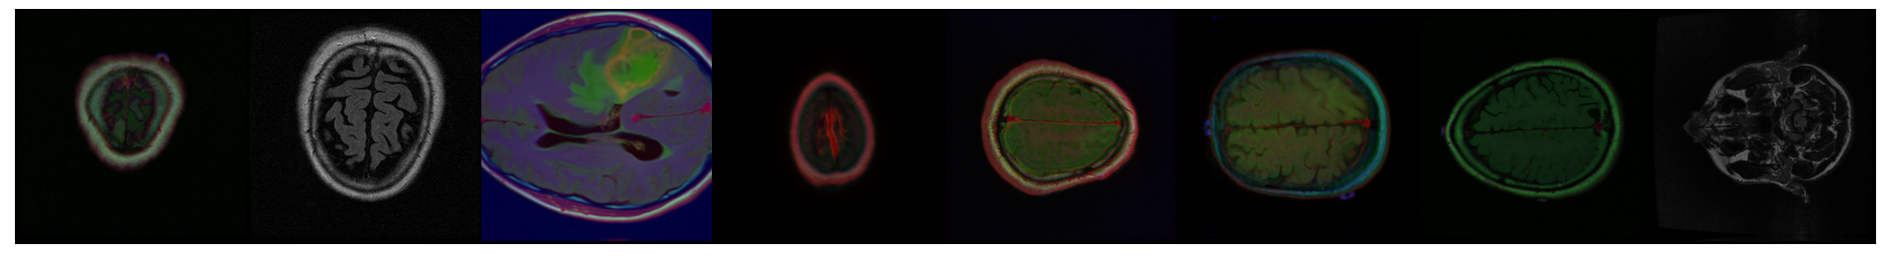

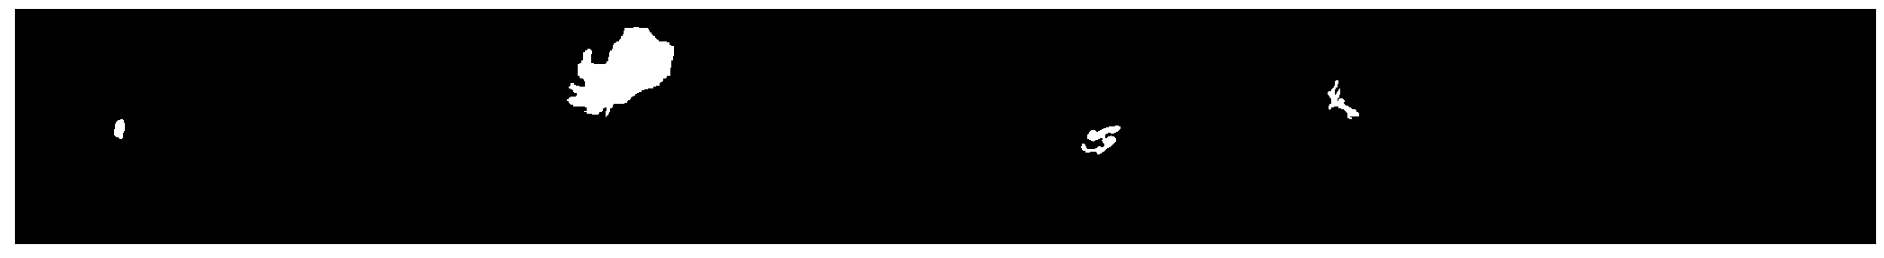

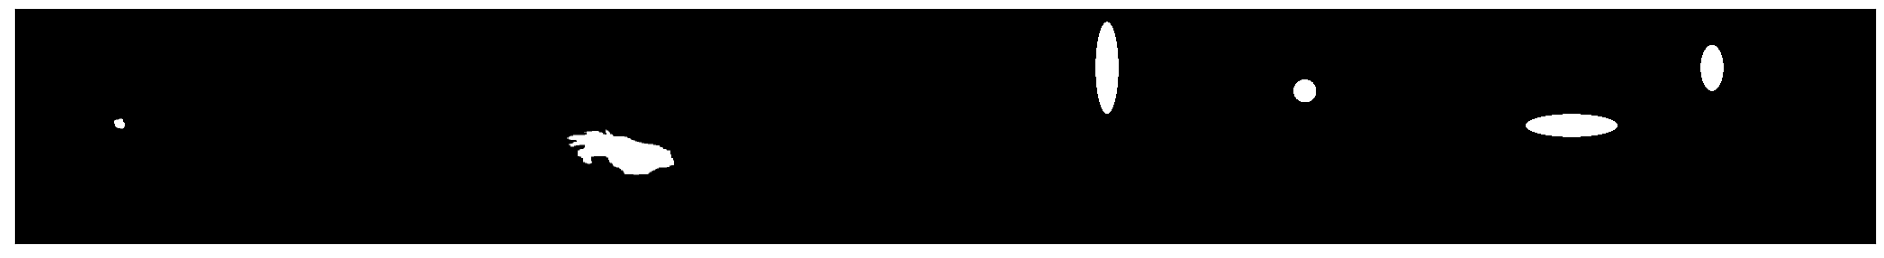

In [17]:
def show_misbatch(dl):
    for images, masks in dl:
        fig1, ax1 = plt.subplots(figsize=(24, 24))
        ax1.set_xticks([]); ax1.set_yticks([])
        denorm_images = denormalize(images)
        ax1.imshow(make_grid(denorm_images[29:37], nrow=13).permute(1, 2, 0).clamp(0,1))
        
        
        fig2, ax2 = plt.subplots(figsize=(24, 24))
        ax2.set_xticks([]); ax2.set_yticks([])
        ax2.imshow(make_grid(masks[29:37], nrow=13).permute(1, 2, 0).clamp(0,1))
        
        fig3, ax3 = plt.subplots(figsize=(24, 24))
        ax3.set_xticks([]); ax3.set_yticks([])
        mismasks = mislabeling(masks, 10)
        ax3.imshow(make_grid(mismasks[29:37], nrow=13).permute(1, 2, 0).clamp(0,1))
        
        break
show_misbatch(train_dl)

### Training loop

In [16]:
def train_loop(model, loader, gamma, config):
    
    loss_func, loss_name, mislabel_rate = config['loss'], config['loss_name'], config['mislabel_rate']
    train_losses = []
    train_pred_out = []
    train_mask_out = []
    gam_update_full = []
    
    model.train()
#   for i, (image, mask) in enumerate(tqdm(loader)):
    for i, (image, mask) in tqdm(enumerate(loader), total=len(loader)):
        image = image.to(device)
        mask = mask.to(device)
        
        '''add mislabel'''
        if mislabel_rate > 0:
            mis_idx = round(mislabel_rate*mask.shape[0])
            mask[:mis_idx] = mislabeling(mask[:mis_idx], i).to(device)
        
        outputs = model(image)
        #outputs = outputs['x_final']
        out_cut = np.copy(outputs.detach().cpu().numpy())
        #out_cut = np.copy(outputs.data.cpu().numpy())
        #append score and info
        train_pred_out.append(out_cut)
        train_mask_out.append(mask.data.cpu().numpy())
        
        '''gamma value'''
        if loss_name == 'gamma_dice_loss':
            #gamma = 0.5
            loss, gam_update = loss_func(outputs, mask, gamma)
            gam_update_full.append(gam_update) #.data.cpu().numpy()
        else:
            loss = loss_func(outputs, mask)
        
        
        train_losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    '''update auto gamma selection'''
    if loss_name == 'gamma_dice_loss':
        gamma = np.mean(gam_update_full)
    
    train_mean_loss = np.mean(train_losses)
    #stack full predicted masks
    train_outs = np.vstack(train_pred_out)
    train_masks = np.vstack(train_mask_out)
    
    train_outs[np.nonzero(train_outs < 0.3)] = 0.0 #thrs=0.5
    train_outs[np.nonzero(train_outs >= 0.3)] = 1.0
    
    train_mean_dice = dice_coef_metric(train_outs, train_masks)
    train_mean_iou = iou_metric(train_outs, train_masks)
    
    
    return train_mean_dice, train_mean_iou, train_mean_loss, gamma

### Validation loop

In [17]:
def eval_loop(model, loader, gamma, config, run, training=True):
    
    loss_func, loss_name, mislabel_rate = config['loss'], config['loss_name'], config['mislabel_rate']
    val_losses = []
    eval_pred_out = []
    eval_mask_out = []
    
    model.eval()
    with torch.no_grad():
        for step, (image, mask) in tqdm(enumerate(loader), total=len(loader)):
            image = image.to(device)
            mask = mask.to(device)
            
            '''mislabeling'''
            if (run == 'val') and (mislabel_rate > 0):
                mis_idx = round(mislabel_rate*mask.shape[0]) #compute mislabel idx for normal/mislabel split
                mask[:mis_idx] = mislabeling(mask[:mis_idx], step).to(device)
            
            
            outputs = model(image)
            #outputs = outputs['x_final']
            '''which loss function'''
            if loss_name == 'gamma_dice_loss':
                #gamma = 0.5
                loss, _ = loss_func(outputs, mask, gamma)
            else:
                loss = loss_func(outputs, mask)
            
            
            out_cut = np.copy(outputs.detach().cpu().numpy())
            '''
            out_cut[np.nonzero(out_cut < 0.3)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.3)] = 1.0
            '''
            #out_cut = np.copy(outputs.data.cpu().numpy())
            
            #append score and info
            eval_pred_out.append(out_cut)
            eval_mask_out.append(mask.data.cpu().numpy())
            
            val_losses.append(loss.cpu().numpy())
            
        eval_mean_loss = np.mean(val_losses)

        
        #stack full predicted masks
        eval_outs = np.vstack(eval_pred_out)
        eval_masks = np.vstack(eval_mask_out)
        
        eval_outs[np.nonzero(eval_outs < 0.3)] = 0.0 #thrs=0.5
        eval_outs[np.nonzero(eval_outs >= 0.3)] = 1.0
        
        eval_mean_dice = dice_coef_metric(eval_outs, eval_masks)
        eval_mean_iou = iou_metric(eval_outs, eval_masks)
        
        if training:
            scheduler.step(eval_mean_dice)
        #scheduler.step()
        
    return eval_mean_dice, eval_mean_iou, eval_mean_loss

### Run train

In [18]:
def save_model(model, save_path):
    """
    Function to save the trained model to disk.
    """
    save_dir = './model_results'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    torch.save(model.state_dict(), os.path.join(save_dir, save_path))

In [19]:
def train_model(model, train_loader, val_loader, optimizer, scheduler, config):
    
    num_epochs, gamma, early_stop = config['n_epochs'], config['gamma'], config['early_stop'] 
    
    train_loss_history, train_dice_history, train_iou_history = [], [], []
    val_loss_history, val_dice_history, val_iou_history = [], [], []
    gamma_history = []
    
    best_iou = 0
    stale = 0
    #early_stop = 10
    for epoch in range(num_epochs):
        train_mean_dice, train_mean_iou, train_mean_loss, gamma = train_loop(model, train_loader, gamma, config)
        val_mean_dice, val_mean_iou, val_mean_loss = eval_loop(model, val_loader, gamma, config, run='val')
        print(f'gamma value in {epoch} epoch:', gamma)
        gamma_history.append(gamma)
        
        #train history
        train_dice_history.append(train_mean_dice)
        train_iou_history.append(train_mean_iou)
        train_loss_history.append(train_mean_loss)
        
        #validation history
        val_dice_history.append(val_mean_dice)
        val_iou_history.append(val_mean_iou)
        val_loss_history.append(val_mean_loss)
        print('Epoch: {}/{} |  Train Loss: {:.3f}, Val Loss: {:.3f}, Train DICE: {:.3f}, Val DICE: {:.3f}, Train IOU: {:.3f}, Val IOU: {:.3f}'.format(epoch+1, num_epochs,
                                                                                                                                            train_mean_loss,
                                                                                                                                            val_mean_loss,
                                                                                                                                            train_mean_dice,
                                                                                                                                            val_mean_dice,
                                                                                                                                            train_mean_iou,
                                                                                                                                            val_mean_iou))
        #early stop
        if val_mean_iou > best_iou:
            best_iou = val_mean_iou
            
            # Save the trained model weights.
            print(f'Save best model at {epoch+1} epoch:')
            ##############################
            ##############################
            # SAVE MODEL NAME
            save_model(model, save_path)
            ##############################
            ##############################
            stale = 0
        else:
            stale += 1
            if stale > early_stop:
                print(f"No improvment {early_stop} consecutive epochs, early stopping")
                break
        
    return train_loss_history, train_dice_history, train_iou_history,  val_loss_history, val_dice_history, val_iou_history, gamma_history

### optimizer

In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate']) #U-net: 1e-3, ResNeXt: 5e-4
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)

## Run training!!!

In [21]:
save_path

'brain-mri-effunet_gamma_dice_loss_cln_0425.pth'

In [22]:
%%time
#change loss function
train_loss_history, train_dice_history, train_iou_history, val_loss_history, val_dice_history, val_iou_history, gamma_history = train_model(model, train_dl, val_dl, optimizer, scheduler, config)

100% 47/47 [00:14<00:00,  3.14it/s]
100% 7/7 [00:01<00:00,  5.74it/s]


gamma value in 0 epoch: 0.5993071
Epoch: 1/150 |  Train Loss: 1.777, Val Loss: 1.394, Train DICE: 0.071, Val DICE: 0.128, Train IOU: 0.037, Val IOU: 0.068
Save best model at 1 epoch:


100% 47/47 [00:12<00:00,  3.64it/s]
100% 7/7 [00:00<00:00,  7.35it/s]


gamma value in 1 epoch: 0.63578486
Epoch: 2/150 |  Train Loss: 1.360, Val Loss: 1.341, Train DICE: 0.581, Val DICE: 0.771, Train IOU: 0.409, Val IOU: 0.628
Save best model at 2 epoch:


100% 47/47 [00:12<00:00,  3.71it/s]
100% 7/7 [00:00<00:00,  7.47it/s]


gamma value in 2 epoch: 0.65836275
Epoch: 3/150 |  Train Loss: 1.296, Val Loss: 1.272, Train DICE: 0.690, Val DICE: 0.796, Train IOU: 0.527, Val IOU: 0.661
Save best model at 3 epoch:


100% 47/47 [00:12<00:00,  3.66it/s]
100% 7/7 [00:00<00:00,  7.05it/s]


gamma value in 3 epoch: 0.678439
Epoch: 4/150 |  Train Loss: 1.222, Val Loss: 1.188, Train DICE: 0.743, Val DICE: 0.724, Train IOU: 0.592, Val IOU: 0.567


100% 47/47 [00:12<00:00,  3.64it/s]
100% 7/7 [00:01<00:00,  6.49it/s]


gamma value in 4 epoch: 0.6958999
Epoch: 5/150 |  Train Loss: 1.127, Val Loss: 1.062, Train DICE: 0.770, Val DICE: 0.778, Train IOU: 0.626, Val IOU: 0.637


100% 47/47 [00:12<00:00,  3.67it/s]
100% 7/7 [00:01<00:00,  6.89it/s]


gamma value in 5 epoch: 0.70727
Epoch: 6/150 |  Train Loss: 0.992, Val Loss: 0.930, Train DICE: 0.816, Val DICE: 0.773, Train IOU: 0.689, Val IOU: 0.630


100% 47/47 [00:12<00:00,  3.69it/s]
100% 7/7 [00:00<00:00,  7.31it/s]


gamma value in 6 epoch: 0.71408284
Epoch: 7/150 |  Train Loss: 0.840, Val Loss: 0.819, Train DICE: 0.846, Val DICE: 0.705, Train IOU: 0.733, Val IOU: 0.544


100% 47/47 [00:12<00:00,  3.63it/s]
100% 7/7 [00:01<00:00,  6.92it/s]


gamma value in 7 epoch: 0.71658057
Epoch: 8/150 |  Train Loss: 0.749, Val Loss: 0.750, Train DICE: 0.863, Val DICE: 0.857, Train IOU: 0.759, Val IOU: 0.750
Save best model at 8 epoch:


100% 47/47 [00:12<00:00,  3.69it/s]
100% 7/7 [00:01<00:00,  6.73it/s]


gamma value in 8 epoch: 0.7170616
Epoch: 9/150 |  Train Loss: 0.725, Val Loss: 0.731, Train DICE: 0.882, Val DICE: 0.864, Train IOU: 0.790, Val IOU: 0.760
Save best model at 9 epoch:


100% 47/47 [00:12<00:00,  3.63it/s]
100% 7/7 [00:01<00:00,  6.97it/s]


gamma value in 9 epoch: 0.7171664
Epoch: 10/150 |  Train Loss: 0.709, Val Loss: 0.712, Train DICE: 0.888, Val DICE: 0.871, Train IOU: 0.799, Val IOU: 0.772
Save best model at 10 epoch:


100% 47/47 [00:12<00:00,  3.62it/s]
100% 7/7 [00:01<00:00,  6.99it/s]


gamma value in 10 epoch: 0.717576
Epoch: 11/150 |  Train Loss: 0.699, Val Loss: 0.699, Train DICE: 0.888, Val DICE: 0.875, Train IOU: 0.799, Val IOU: 0.777
Save best model at 11 epoch:


100% 47/47 [00:12<00:00,  3.68it/s]
100% 7/7 [00:00<00:00,  7.50it/s]


gamma value in 11 epoch: 0.7176738
Epoch: 12/150 |  Train Loss: 0.688, Val Loss: 0.693, Train DICE: 0.893, Val DICE: 0.882, Train IOU: 0.806, Val IOU: 0.788
Save best model at 12 epoch:


100% 47/47 [00:12<00:00,  3.68it/s]
100% 7/7 [00:00<00:00,  7.28it/s]


gamma value in 12 epoch: 0.71813107
Epoch: 13/150 |  Train Loss: 0.677, Val Loss: 0.682, Train DICE: 0.894, Val DICE: 0.876, Train IOU: 0.808, Val IOU: 0.779


100% 47/47 [00:12<00:00,  3.73it/s]
100% 7/7 [00:00<00:00,  7.43it/s]


gamma value in 13 epoch: 0.71808475
Epoch: 14/150 |  Train Loss: 0.667, Val Loss: 0.669, Train DICE: 0.896, Val DICE: 0.889, Train IOU: 0.811, Val IOU: 0.800
Save best model at 14 epoch:


100% 47/47 [00:12<00:00,  3.74it/s]
100% 7/7 [00:00<00:00,  7.44it/s]


gamma value in 14 epoch: 0.7183288
Epoch: 15/150 |  Train Loss: 0.655, Val Loss: 0.658, Train DICE: 0.900, Val DICE: 0.887, Train IOU: 0.818, Val IOU: 0.797


100% 47/47 [00:12<00:00,  3.71it/s]
100% 7/7 [00:00<00:00,  7.05it/s]


gamma value in 15 epoch: 0.7184421
Epoch: 16/150 |  Train Loss: 0.650, Val Loss: 0.647, Train DICE: 0.899, Val DICE: 0.889, Train IOU: 0.817, Val IOU: 0.801
Save best model at 16 epoch:


100% 47/47 [00:12<00:00,  3.69it/s]
100% 7/7 [00:01<00:00,  6.76it/s]


gamma value in 16 epoch: 0.71904415
Epoch: 17/150 |  Train Loss: 0.637, Val Loss: 0.641, Train DICE: 0.902, Val DICE: 0.892, Train IOU: 0.821, Val IOU: 0.805
Save best model at 17 epoch:


100% 47/47 [00:12<00:00,  3.65it/s]
100% 7/7 [00:00<00:00,  7.28it/s]


gamma value in 17 epoch: 0.71874356
Epoch: 18/150 |  Train Loss: 0.627, Val Loss: 0.629, Train DICE: 0.905, Val DICE: 0.897, Train IOU: 0.826, Val IOU: 0.812
Save best model at 18 epoch:


100% 47/47 [00:13<00:00,  3.54it/s]
100% 7/7 [00:00<00:00,  7.59it/s]


gamma value in 18 epoch: 0.71883637
Epoch: 19/150 |  Train Loss: 0.620, Val Loss: 0.625, Train DICE: 0.903, Val DICE: 0.892, Train IOU: 0.824, Val IOU: 0.805


100% 47/47 [00:12<00:00,  3.70it/s]
100% 7/7 [00:00<00:00,  7.06it/s]


gamma value in 19 epoch: 0.7189832
Epoch: 20/150 |  Train Loss: 0.611, Val Loss: 0.617, Train DICE: 0.906, Val DICE: 0.898, Train IOU: 0.829, Val IOU: 0.814
Save best model at 20 epoch:


100% 47/47 [00:12<00:00,  3.68it/s]
100% 7/7 [00:00<00:00,  7.11it/s]


gamma value in 20 epoch: 0.719158
Epoch: 21/150 |  Train Loss: 0.605, Val Loss: 0.611, Train DICE: 0.906, Val DICE: 0.892, Train IOU: 0.828, Val IOU: 0.805


100% 47/47 [00:12<00:00,  3.69it/s]
100% 7/7 [00:01<00:00,  6.88it/s]


gamma value in 21 epoch: 0.7191979
Epoch: 22/150 |  Train Loss: 0.597, Val Loss: 0.607, Train DICE: 0.908, Val DICE: 0.893, Train IOU: 0.831, Val IOU: 0.806


100% 47/47 [00:12<00:00,  3.69it/s]
100% 7/7 [00:00<00:00,  7.06it/s]


gamma value in 22 epoch: 0.7192987
Epoch: 23/150 |  Train Loss: 0.593, Val Loss: 0.594, Train DICE: 0.908, Val DICE: 0.895, Train IOU: 0.832, Val IOU: 0.810


100% 47/47 [00:12<00:00,  3.67it/s]
100% 7/7 [00:01<00:00,  5.98it/s]


gamma value in 23 epoch: 0.71944547
Epoch: 24/150 |  Train Loss: 0.585, Val Loss: 0.593, Train DICE: 0.908, Val DICE: 0.894, Train IOU: 0.832, Val IOU: 0.808


100% 47/47 [00:12<00:00,  3.66it/s]
100% 7/7 [00:00<00:00,  7.15it/s]


gamma value in 24 epoch: 0.719449
Epoch: 25/150 |  Train Loss: 0.577, Val Loss: 0.594, Train DICE: 0.910, Val DICE: 0.895, Train IOU: 0.836, Val IOU: 0.810


100% 47/47 [00:12<00:00,  3.74it/s]
100% 7/7 [00:01<00:00,  6.91it/s]


gamma value in 25 epoch: 0.719532
Epoch: 26/150 |  Train Loss: 0.578, Val Loss: 0.587, Train DICE: 0.912, Val DICE: 0.898, Train IOU: 0.838, Val IOU: 0.814
Save best model at 26 epoch:


100% 47/47 [00:12<00:00,  3.64it/s]
100% 7/7 [00:01<00:00,  6.58it/s]


gamma value in 26 epoch: 0.7194653
Epoch: 27/150 |  Train Loss: 0.577, Val Loss: 0.594, Train DICE: 0.911, Val DICE: 0.895, Train IOU: 0.837, Val IOU: 0.809


100% 47/47 [00:12<00:00,  3.70it/s]
100% 7/7 [00:01<00:00,  6.92it/s]


gamma value in 27 epoch: 0.7194809
Epoch: 28/150 |  Train Loss: 0.577, Val Loss: 0.588, Train DICE: 0.913, Val DICE: 0.896, Train IOU: 0.839, Val IOU: 0.811


100% 47/47 [00:12<00:00,  3.69it/s]
100% 7/7 [00:00<00:00,  7.00it/s]


gamma value in 28 epoch: 0.7195555
Epoch: 29/150 |  Train Loss: 0.579, Val Loss: 0.587, Train DICE: 0.912, Val DICE: 0.895, Train IOU: 0.838, Val IOU: 0.810


100% 47/47 [00:13<00:00,  3.54it/s]
100% 7/7 [00:01<00:00,  6.66it/s]


gamma value in 29 epoch: 0.7195847
Epoch: 30/150 |  Train Loss: 0.579, Val Loss: 0.591, Train DICE: 0.910, Val DICE: 0.895, Train IOU: 0.836, Val IOU: 0.809


100% 47/47 [00:12<00:00,  3.68it/s]
100% 7/7 [00:01<00:00,  6.79it/s]


gamma value in 30 epoch: 0.7195066
Epoch: 31/150 |  Train Loss: 0.577, Val Loss: 0.587, Train DICE: 0.912, Val DICE: 0.896, Train IOU: 0.838, Val IOU: 0.812


100% 47/47 [00:13<00:00,  3.59it/s]
100% 7/7 [00:00<00:00,  7.15it/s]


gamma value in 31 epoch: 0.71957934
Epoch: 32/150 |  Train Loss: 0.579, Val Loss: 0.589, Train DICE: 0.911, Val DICE: 0.897, Train IOU: 0.836, Val IOU: 0.813


100% 47/47 [00:12<00:00,  3.70it/s]
100% 7/7 [00:01<00:00,  6.48it/s]


gamma value in 32 epoch: 0.71950036
Epoch: 33/150 |  Train Loss: 0.579, Val Loss: 0.589, Train DICE: 0.910, Val DICE: 0.894, Train IOU: 0.834, Val IOU: 0.809


100% 47/47 [00:13<00:00,  3.56it/s]
100% 7/7 [00:00<00:00,  7.05it/s]


gamma value in 33 epoch: 0.7195865
Epoch: 34/150 |  Train Loss: 0.573, Val Loss: 0.592, Train DICE: 0.913, Val DICE: 0.894, Train IOU: 0.839, Val IOU: 0.808


100% 47/47 [00:13<00:00,  3.61it/s]
100% 7/7 [00:01<00:00,  6.53it/s]


gamma value in 34 epoch: 0.7195055
Epoch: 35/150 |  Train Loss: 0.574, Val Loss: 0.586, Train DICE: 0.913, Val DICE: 0.897, Train IOU: 0.840, Val IOU: 0.813


100% 47/47 [00:12<00:00,  3.63it/s]
100% 7/7 [00:00<00:00,  7.14it/s]


gamma value in 35 epoch: 0.7195065
Epoch: 36/150 |  Train Loss: 0.575, Val Loss: 0.586, Train DICE: 0.912, Val DICE: 0.897, Train IOU: 0.839, Val IOU: 0.813


100% 47/47 [00:12<00:00,  3.65it/s]
100% 7/7 [00:00<00:00,  7.06it/s]


gamma value in 36 epoch: 0.71951693
Epoch: 37/150 |  Train Loss: 0.575, Val Loss: 0.586, Train DICE: 0.912, Val DICE: 0.895, Train IOU: 0.839, Val IOU: 0.810


100% 47/47 [00:12<00:00,  3.70it/s]
100% 7/7 [00:01<00:00,  6.16it/s]


gamma value in 37 epoch: 0.7195091
Epoch: 38/150 |  Train Loss: 0.579, Val Loss: 0.586, Train DICE: 0.911, Val DICE: 0.896, Train IOU: 0.837, Val IOU: 0.812


100% 47/47 [00:12<00:00,  3.71it/s]
100% 7/7 [00:01<00:00,  6.70it/s]


gamma value in 38 epoch: 0.7196253
Epoch: 39/150 |  Train Loss: 0.575, Val Loss: 0.589, Train DICE: 0.912, Val DICE: 0.895, Train IOU: 0.837, Val IOU: 0.809


100% 47/47 [00:12<00:00,  3.69it/s]
100% 7/7 [00:00<00:00,  7.39it/s]


gamma value in 39 epoch: 0.71955675
Epoch: 40/150 |  Train Loss: 0.578, Val Loss: 0.590, Train DICE: 0.910, Val DICE: 0.892, Train IOU: 0.835, Val IOU: 0.805


100% 47/47 [00:12<00:00,  3.71it/s]
100% 7/7 [00:01<00:00,  6.19it/s]


gamma value in 40 epoch: 0.71951026
Epoch: 41/150 |  Train Loss: 0.577, Val Loss: 0.588, Train DICE: 0.912, Val DICE: 0.894, Train IOU: 0.838, Val IOU: 0.809


100% 47/47 [00:12<00:00,  3.65it/s]
100% 7/7 [00:00<00:00,  7.36it/s]


gamma value in 41 epoch: 0.71953964
Epoch: 42/150 |  Train Loss: 0.576, Val Loss: 0.593, Train DICE: 0.912, Val DICE: 0.892, Train IOU: 0.839, Val IOU: 0.806


100% 47/47 [00:12<00:00,  3.62it/s]
100% 7/7 [00:00<00:00,  7.22it/s]


gamma value in 42 epoch: 0.71950597
Epoch: 43/150 |  Train Loss: 0.576, Val Loss: 0.586, Train DICE: 0.912, Val DICE: 0.896, Train IOU: 0.838, Val IOU: 0.811


100% 47/47 [00:12<00:00,  3.70it/s]
100% 7/7 [00:00<00:00,  7.28it/s]


gamma value in 43 epoch: 0.71950597
Epoch: 44/150 |  Train Loss: 0.576, Val Loss: 0.587, Train DICE: 0.911, Val DICE: 0.894, Train IOU: 0.836, Val IOU: 0.809


100% 47/47 [00:12<00:00,  3.74it/s]
100% 7/7 [00:01<00:00,  6.27it/s]


gamma value in 44 epoch: 0.7195066
Epoch: 45/150 |  Train Loss: 0.572, Val Loss: 0.588, Train DICE: 0.913, Val DICE: 0.895, Train IOU: 0.840, Val IOU: 0.810


100% 47/47 [00:12<00:00,  3.66it/s]
100% 7/7 [00:01<00:00,  6.91it/s]


gamma value in 45 epoch: 0.71950686
Epoch: 46/150 |  Train Loss: 0.577, Val Loss: 0.589, Train DICE: 0.912, Val DICE: 0.894, Train IOU: 0.838, Val IOU: 0.808


100% 47/47 [00:12<00:00,  3.69it/s]
100% 7/7 [00:00<00:00,  7.09it/s]


gamma value in 46 epoch: 0.71950644
Epoch: 47/150 |  Train Loss: 0.575, Val Loss: 0.587, Train DICE: 0.912, Val DICE: 0.896, Train IOU: 0.838, Val IOU: 0.812


100% 47/47 [00:12<00:00,  3.66it/s]
100% 7/7 [00:00<00:00,  7.24it/s]


gamma value in 47 epoch: 0.71955293
Epoch: 48/150 |  Train Loss: 0.575, Val Loss: 0.588, Train DICE: 0.912, Val DICE: 0.894, Train IOU: 0.838, Val IOU: 0.809


100% 47/47 [00:12<00:00,  3.67it/s]
100% 7/7 [00:00<00:00,  7.34it/s]


gamma value in 48 epoch: 0.71950734
Epoch: 49/150 |  Train Loss: 0.571, Val Loss: 0.586, Train DICE: 0.913, Val DICE: 0.895, Train IOU: 0.840, Val IOU: 0.810


100% 47/47 [00:12<00:00,  3.68it/s]
100% 7/7 [00:00<00:00,  7.66it/s]


gamma value in 49 epoch: 0.71951085
Epoch: 50/150 |  Train Loss: 0.578, Val Loss: 0.586, Train DICE: 0.912, Val DICE: 0.897, Train IOU: 0.838, Val IOU: 0.813


100% 47/47 [00:12<00:00,  3.70it/s]
100% 7/7 [00:01<00:00,  6.92it/s]


gamma value in 50 epoch: 0.7195271
Epoch: 51/150 |  Train Loss: 0.576, Val Loss: 0.585, Train DICE: 0.912, Val DICE: 0.897, Train IOU: 0.838, Val IOU: 0.813


100% 47/47 [00:12<00:00,  3.66it/s]
100% 7/7 [00:00<00:00,  7.22it/s]


gamma value in 51 epoch: 0.7195087
Epoch: 52/150 |  Train Loss: 0.577, Val Loss: 0.588, Train DICE: 0.911, Val DICE: 0.894, Train IOU: 0.837, Val IOU: 0.809


100% 47/47 [00:12<00:00,  3.66it/s]
100% 7/7 [00:00<00:00,  7.33it/s]


gamma value in 52 epoch: 0.71950436
Epoch: 53/150 |  Train Loss: 0.572, Val Loss: 0.589, Train DICE: 0.913, Val DICE: 0.894, Train IOU: 0.841, Val IOU: 0.809


100% 47/47 [00:12<00:00,  3.70it/s]
100% 7/7 [00:01<00:00,  6.35it/s]


gamma value in 53 epoch: 0.71951455
Epoch: 54/150 |  Train Loss: 0.579, Val Loss: 0.588, Train DICE: 0.911, Val DICE: 0.893, Train IOU: 0.837, Val IOU: 0.807


100% 47/47 [00:12<00:00,  3.67it/s]
100% 7/7 [00:00<00:00,  7.40it/s]


gamma value in 54 epoch: 0.7195098
Epoch: 55/150 |  Train Loss: 0.572, Val Loss: 0.587, Train DICE: 0.913, Val DICE: 0.895, Train IOU: 0.840, Val IOU: 0.810


100% 47/47 [00:12<00:00,  3.62it/s]
100% 7/7 [00:00<00:00,  7.34it/s]


gamma value in 55 epoch: 0.7195047
Epoch: 56/150 |  Train Loss: 0.574, Val Loss: 0.588, Train DICE: 0.914, Val DICE: 0.894, Train IOU: 0.842, Val IOU: 0.809


100% 47/47 [00:12<00:00,  3.70it/s]
100% 7/7 [00:01<00:00,  6.58it/s]


gamma value in 56 epoch: 0.71952254
Epoch: 57/150 |  Train Loss: 0.573, Val Loss: 0.591, Train DICE: 0.913, Val DICE: 0.894, Train IOU: 0.840, Val IOU: 0.809


100% 47/47 [00:12<00:00,  3.69it/s]
100% 7/7 [00:00<00:00,  7.32it/s]


gamma value in 57 epoch: 0.7195075
Epoch: 58/150 |  Train Loss: 0.577, Val Loss: 0.593, Train DICE: 0.913, Val DICE: 0.892, Train IOU: 0.839, Val IOU: 0.806


100% 47/47 [00:12<00:00,  3.73it/s]
100% 7/7 [00:00<00:00,  7.55it/s]


gamma value in 58 epoch: 0.7195097
Epoch: 59/150 |  Train Loss: 0.575, Val Loss: 0.588, Train DICE: 0.913, Val DICE: 0.895, Train IOU: 0.839, Val IOU: 0.810


100% 47/47 [00:12<00:00,  3.75it/s]
100% 7/7 [00:01<00:00,  6.85it/s]


gamma value in 59 epoch: 0.71952444
Epoch: 60/150 |  Train Loss: 0.578, Val Loss: 0.589, Train DICE: 0.912, Val DICE: 0.895, Train IOU: 0.838, Val IOU: 0.809


100% 47/47 [00:12<00:00,  3.69it/s]
100% 7/7 [00:01<00:00,  6.99it/s]


gamma value in 60 epoch: 0.71950376
Epoch: 61/150 |  Train Loss: 0.577, Val Loss: 0.586, Train DICE: 0.911, Val DICE: 0.896, Train IOU: 0.837, Val IOU: 0.812


100% 47/47 [00:12<00:00,  3.68it/s]
100% 7/7 [00:00<00:00,  7.14it/s]


gamma value in 61 epoch: 0.71955675
Epoch: 62/150 |  Train Loss: 0.576, Val Loss: 0.591, Train DICE: 0.912, Val DICE: 0.894, Train IOU: 0.838, Val IOU: 0.808


100% 47/47 [00:12<00:00,  3.69it/s]
100% 7/7 [00:01<00:00,  5.91it/s]


gamma value in 62 epoch: 0.71955514
Epoch: 63/150 |  Train Loss: 0.578, Val Loss: 0.588, Train DICE: 0.912, Val DICE: 0.896, Train IOU: 0.837, Val IOU: 0.812


100% 47/47 [00:12<00:00,  3.71it/s]
100% 7/7 [00:00<00:00,  7.77it/s]


gamma value in 63 epoch: 0.7195205
Epoch: 64/150 |  Train Loss: 0.578, Val Loss: 0.592, Train DICE: 0.912, Val DICE: 0.893, Train IOU: 0.839, Val IOU: 0.807


100% 47/47 [00:12<00:00,  3.67it/s]
100% 7/7 [00:00<00:00,  7.04it/s]


gamma value in 64 epoch: 0.7195075
Epoch: 65/150 |  Train Loss: 0.575, Val Loss: 0.590, Train DICE: 0.913, Val DICE: 0.893, Train IOU: 0.840, Val IOU: 0.806


100% 47/47 [00:12<00:00,  3.69it/s]
100% 7/7 [00:01<00:00,  6.76it/s]


gamma value in 65 epoch: 0.7195114
Epoch: 66/150 |  Train Loss: 0.573, Val Loss: 0.592, Train DICE: 0.913, Val DICE: 0.893, Train IOU: 0.840, Val IOU: 0.807


100% 47/47 [00:12<00:00,  3.64it/s]
100% 7/7 [00:00<00:00,  7.29it/s]


gamma value in 66 epoch: 0.71950865
Epoch: 67/150 |  Train Loss: 0.574, Val Loss: 0.591, Train DICE: 0.913, Val DICE: 0.895, Train IOU: 0.839, Val IOU: 0.809


100% 47/47 [00:12<00:00,  3.68it/s]
100% 7/7 [00:01<00:00,  6.49it/s]


gamma value in 67 epoch: 0.71955174
Epoch: 68/150 |  Train Loss: 0.575, Val Loss: 0.592, Train DICE: 0.912, Val DICE: 0.894, Train IOU: 0.839, Val IOU: 0.808


100% 47/47 [00:13<00:00,  3.62it/s]
100% 7/7 [00:01<00:00,  6.89it/s]


gamma value in 68 epoch: 0.71950597
Epoch: 69/150 |  Train Loss: 0.579, Val Loss: 0.586, Train DICE: 0.911, Val DICE: 0.896, Train IOU: 0.836, Val IOU: 0.812


100% 47/47 [00:13<00:00,  3.58it/s]
100% 7/7 [00:01<00:00,  6.44it/s]


gamma value in 69 epoch: 0.71950626
Epoch: 70/150 |  Train Loss: 0.574, Val Loss: 0.588, Train DICE: 0.912, Val DICE: 0.896, Train IOU: 0.838, Val IOU: 0.811


100% 47/47 [00:13<00:00,  3.57it/s]
100% 7/7 [00:00<00:00,  7.44it/s]


gamma value in 70 epoch: 0.71950614
Epoch: 71/150 |  Train Loss: 0.574, Val Loss: 0.595, Train DICE: 0.913, Val DICE: 0.891, Train IOU: 0.839, Val IOU: 0.804


100% 47/47 [00:12<00:00,  3.72it/s]
100% 7/7 [00:01<00:00,  6.74it/s]


gamma value in 71 epoch: 0.71955246
Epoch: 72/150 |  Train Loss: 0.575, Val Loss: 0.586, Train DICE: 0.912, Val DICE: 0.895, Train IOU: 0.838, Val IOU: 0.810


100% 47/47 [00:12<00:00,  3.70it/s]
100% 7/7 [00:01<00:00,  6.91it/s]


gamma value in 72 epoch: 0.7195109
Epoch: 73/150 |  Train Loss: 0.576, Val Loss: 0.590, Train DICE: 0.912, Val DICE: 0.894, Train IOU: 0.839, Val IOU: 0.808


100% 47/47 [00:12<00:00,  3.66it/s]
100% 7/7 [00:00<00:00,  7.32it/s]


gamma value in 73 epoch: 0.71960896
Epoch: 74/150 |  Train Loss: 0.577, Val Loss: 0.590, Train DICE: 0.912, Val DICE: 0.896, Train IOU: 0.838, Val IOU: 0.812


100% 47/47 [00:13<00:00,  3.59it/s]
100% 7/7 [00:01<00:00,  6.78it/s]


gamma value in 74 epoch: 0.71950513
Epoch: 75/150 |  Train Loss: 0.571, Val Loss: 0.589, Train DICE: 0.914, Val DICE: 0.895, Train IOU: 0.841, Val IOU: 0.810


100% 47/47 [00:12<00:00,  3.67it/s]
100% 7/7 [00:00<00:00,  7.05it/s]


gamma value in 75 epoch: 0.7195406
Epoch: 76/150 |  Train Loss: 0.575, Val Loss: 0.590, Train DICE: 0.912, Val DICE: 0.895, Train IOU: 0.839, Val IOU: 0.810


100% 47/47 [00:12<00:00,  3.65it/s]
100% 7/7 [00:00<00:00,  7.33it/s]


gamma value in 76 epoch: 0.7195358
Epoch: 77/150 |  Train Loss: 0.575, Val Loss: 0.588, Train DICE: 0.912, Val DICE: 0.896, Train IOU: 0.839, Val IOU: 0.811


100% 47/47 [00:12<00:00,  3.71it/s]
100% 7/7 [00:01<00:00,  6.89it/s]


gamma value in 77 epoch: 0.7195197
Epoch: 78/150 |  Train Loss: 0.577, Val Loss: 0.589, Train DICE: 0.911, Val DICE: 0.896, Train IOU: 0.836, Val IOU: 0.812


100% 47/47 [00:12<00:00,  3.69it/s]
100% 7/7 [00:00<00:00,  7.11it/s]


gamma value in 78 epoch: 0.71988875
Epoch: 79/150 |  Train Loss: 0.574, Val Loss: 0.588, Train DICE: 0.913, Val DICE: 0.896, Train IOU: 0.840, Val IOU: 0.811


100% 47/47 [00:12<00:00,  3.69it/s]
100% 7/7 [00:00<00:00,  7.37it/s]


gamma value in 79 epoch: 0.7195045
Epoch: 80/150 |  Train Loss: 0.575, Val Loss: 0.591, Train DICE: 0.911, Val DICE: 0.896, Train IOU: 0.837, Val IOU: 0.811


100% 47/47 [00:13<00:00,  3.55it/s]
100% 7/7 [00:00<00:00,  7.11it/s]


gamma value in 80 epoch: 0.71951973
Epoch: 81/150 |  Train Loss: 0.574, Val Loss: 0.586, Train DICE: 0.912, Val DICE: 0.895, Train IOU: 0.838, Val IOU: 0.809


100% 47/47 [00:12<00:00,  3.66it/s]
100% 7/7 [00:00<00:00,  7.73it/s]


gamma value in 81 epoch: 0.7195064
Epoch: 82/150 |  Train Loss: 0.576, Val Loss: 0.588, Train DICE: 0.911, Val DICE: 0.894, Train IOU: 0.836, Val IOU: 0.808


100% 47/47 [00:12<00:00,  3.72it/s]
100% 7/7 [00:00<00:00,  7.43it/s]


gamma value in 82 epoch: 0.7195212
Epoch: 83/150 |  Train Loss: 0.577, Val Loss: 0.589, Train DICE: 0.913, Val DICE: 0.894, Train IOU: 0.839, Val IOU: 0.809


100% 47/47 [00:12<00:00,  3.72it/s]
100% 7/7 [00:00<00:00,  7.33it/s]


gamma value in 83 epoch: 0.71950716
Epoch: 84/150 |  Train Loss: 0.575, Val Loss: 0.587, Train DICE: 0.912, Val DICE: 0.897, Train IOU: 0.839, Val IOU: 0.812


100% 47/47 [00:12<00:00,  3.67it/s]
100% 7/7 [00:00<00:00,  7.45it/s]


gamma value in 84 epoch: 0.71950465
Epoch: 85/150 |  Train Loss: 0.573, Val Loss: 0.587, Train DICE: 0.914, Val DICE: 0.894, Train IOU: 0.842, Val IOU: 0.809


100% 47/47 [00:13<00:00,  3.59it/s]
100% 7/7 [00:01<00:00,  6.72it/s]


gamma value in 85 epoch: 0.71951604
Epoch: 86/150 |  Train Loss: 0.575, Val Loss: 0.585, Train DICE: 0.912, Val DICE: 0.895, Train IOU: 0.839, Val IOU: 0.811


100% 47/47 [00:12<00:00,  3.68it/s]
100% 7/7 [00:01<00:00,  6.61it/s]


gamma value in 86 epoch: 0.7195123
Epoch: 87/150 |  Train Loss: 0.576, Val Loss: 0.588, Train DICE: 0.912, Val DICE: 0.893, Train IOU: 0.839, Val IOU: 0.807


100% 47/47 [00:12<00:00,  3.71it/s]
100% 7/7 [00:00<00:00,  7.17it/s]


gamma value in 87 epoch: 0.7196175
Epoch: 88/150 |  Train Loss: 0.579, Val Loss: 0.589, Train DICE: 0.911, Val DICE: 0.895, Train IOU: 0.837, Val IOU: 0.810


100% 47/47 [00:12<00:00,  3.65it/s]
100% 7/7 [00:01<00:00,  6.65it/s]


gamma value in 88 epoch: 0.71950847
Epoch: 89/150 |  Train Loss: 0.575, Val Loss: 0.589, Train DICE: 0.912, Val DICE: 0.893, Train IOU: 0.839, Val IOU: 0.807


100% 47/47 [00:12<00:00,  3.65it/s]
100% 7/7 [00:01<00:00,  6.84it/s]


gamma value in 89 epoch: 0.71967024
Epoch: 90/150 |  Train Loss: 0.575, Val Loss: 0.588, Train DICE: 0.913, Val DICE: 0.895, Train IOU: 0.839, Val IOU: 0.810


100% 47/47 [00:12<00:00,  3.72it/s]
100% 7/7 [00:00<00:00,  7.08it/s]


gamma value in 90 epoch: 0.7195082
Epoch: 91/150 |  Train Loss: 0.577, Val Loss: 0.588, Train DICE: 0.911, Val DICE: 0.894, Train IOU: 0.837, Val IOU: 0.809


100% 47/47 [00:13<00:00,  3.59it/s]
100% 7/7 [00:01<00:00,  6.48it/s]


gamma value in 91 epoch: 0.71950907
Epoch: 92/150 |  Train Loss: 0.573, Val Loss: 0.585, Train DICE: 0.913, Val DICE: 0.896, Train IOU: 0.840, Val IOU: 0.811


100% 47/47 [00:12<00:00,  3.72it/s]
100% 7/7 [00:01<00:00,  6.82it/s]


gamma value in 92 epoch: 0.7195194
Epoch: 93/150 |  Train Loss: 0.575, Val Loss: 0.587, Train DICE: 0.912, Val DICE: 0.897, Train IOU: 0.839, Val IOU: 0.812


100% 47/47 [00:12<00:00,  3.64it/s]
100% 7/7 [00:01<00:00,  6.55it/s]


gamma value in 93 epoch: 0.71950704
Epoch: 94/150 |  Train Loss: 0.580, Val Loss: 0.587, Train DICE: 0.910, Val DICE: 0.895, Train IOU: 0.835, Val IOU: 0.810


100% 47/47 [00:12<00:00,  3.69it/s]
100% 7/7 [00:00<00:00,  7.06it/s]


gamma value in 94 epoch: 0.7195031
Epoch: 95/150 |  Train Loss: 0.575, Val Loss: 0.588, Train DICE: 0.912, Val DICE: 0.894, Train IOU: 0.839, Val IOU: 0.808


100% 47/47 [00:12<00:00,  3.64it/s]
100% 7/7 [00:01<00:00,  6.56it/s]


gamma value in 95 epoch: 0.7195042
Epoch: 96/150 |  Train Loss: 0.578, Val Loss: 0.586, Train DICE: 0.912, Val DICE: 0.896, Train IOU: 0.838, Val IOU: 0.812


100% 47/47 [00:13<00:00,  3.61it/s]
100% 7/7 [00:01<00:00,  6.42it/s]


gamma value in 96 epoch: 0.71950644
Epoch: 97/150 |  Train Loss: 0.577, Val Loss: 0.591, Train DICE: 0.911, Val DICE: 0.894, Train IOU: 0.837, Val IOU: 0.809


100% 47/47 [00:12<00:00,  3.64it/s]
100% 7/7 [00:01<00:00,  6.66it/s]


gamma value in 97 epoch: 0.7195122
Epoch: 98/150 |  Train Loss: 0.577, Val Loss: 0.591, Train DICE: 0.912, Val DICE: 0.894, Train IOU: 0.838, Val IOU: 0.808


100% 47/47 [00:12<00:00,  3.63it/s]
100% 7/7 [00:00<00:00,  7.33it/s]


gamma value in 98 epoch: 0.7195053
Epoch: 99/150 |  Train Loss: 0.576, Val Loss: 0.587, Train DICE: 0.912, Val DICE: 0.896, Train IOU: 0.839, Val IOU: 0.811


100% 47/47 [00:12<00:00,  3.69it/s]
100% 7/7 [00:00<00:00,  7.42it/s]


gamma value in 99 epoch: 0.7195075
Epoch: 100/150 |  Train Loss: 0.573, Val Loss: 0.592, Train DICE: 0.913, Val DICE: 0.893, Train IOU: 0.839, Val IOU: 0.807


100% 47/47 [00:12<00:00,  3.64it/s]
100% 7/7 [00:00<00:00,  7.01it/s]


gamma value in 100 epoch: 0.7196197
Epoch: 101/150 |  Train Loss: 0.575, Val Loss: 0.587, Train DICE: 0.913, Val DICE: 0.895, Train IOU: 0.840, Val IOU: 0.810


100% 47/47 [00:13<00:00,  3.61it/s]
100% 7/7 [00:01<00:00,  6.74it/s]


gamma value in 101 epoch: 0.7195132
Epoch: 102/150 |  Train Loss: 0.581, Val Loss: 0.593, Train DICE: 0.911, Val DICE: 0.893, Train IOU: 0.837, Val IOU: 0.807


100% 47/47 [00:12<00:00,  3.64it/s]
100% 7/7 [00:00<00:00,  7.40it/s]


gamma value in 102 epoch: 0.71958053
Epoch: 103/150 |  Train Loss: 0.574, Val Loss: 0.587, Train DICE: 0.913, Val DICE: 0.895, Train IOU: 0.840, Val IOU: 0.811


100% 47/47 [00:12<00:00,  3.73it/s]
100% 7/7 [00:01<00:00,  6.96it/s]


gamma value in 103 epoch: 0.71951044
Epoch: 104/150 |  Train Loss: 0.577, Val Loss: 0.588, Train DICE: 0.912, Val DICE: 0.896, Train IOU: 0.838, Val IOU: 0.811


100% 47/47 [00:12<00:00,  3.71it/s]
100% 7/7 [00:00<00:00,  7.37it/s]


gamma value in 104 epoch: 0.71950686
Epoch: 105/150 |  Train Loss: 0.577, Val Loss: 0.586, Train DICE: 0.912, Val DICE: 0.895, Train IOU: 0.838, Val IOU: 0.810


100% 47/47 [00:12<00:00,  3.69it/s]
100% 7/7 [00:01<00:00,  6.52it/s]


gamma value in 105 epoch: 0.7194962
Epoch: 106/150 |  Train Loss: 0.576, Val Loss: 0.588, Train DICE: 0.912, Val DICE: 0.896, Train IOU: 0.838, Val IOU: 0.812


100% 47/47 [00:12<00:00,  3.65it/s]
100% 7/7 [00:00<00:00,  7.05it/s]


gamma value in 106 epoch: 0.7195883
Epoch: 107/150 |  Train Loss: 0.576, Val Loss: 0.587, Train DICE: 0.912, Val DICE: 0.895, Train IOU: 0.838, Val IOU: 0.810


100% 47/47 [00:12<00:00,  3.69it/s]
100% 7/7 [00:00<00:00,  7.16it/s]


gamma value in 107 epoch: 0.71950984
Epoch: 108/150 |  Train Loss: 0.576, Val Loss: 0.590, Train DICE: 0.912, Val DICE: 0.893, Train IOU: 0.838, Val IOU: 0.807


100% 47/47 [00:12<00:00,  3.71it/s]
100% 7/7 [00:00<00:00,  7.66it/s]


gamma value in 108 epoch: 0.719532
Epoch: 109/150 |  Train Loss: 0.574, Val Loss: 0.590, Train DICE: 0.913, Val DICE: 0.894, Train IOU: 0.840, Val IOU: 0.808


100% 47/47 [00:12<00:00,  3.71it/s]
100% 7/7 [00:00<00:00,  7.12it/s]


gamma value in 109 epoch: 0.7195098
Epoch: 110/150 |  Train Loss: 0.577, Val Loss: 0.591, Train DICE: 0.911, Val DICE: 0.894, Train IOU: 0.837, Val IOU: 0.808


100% 47/47 [00:12<00:00,  3.65it/s]
100% 7/7 [00:01<00:00,  6.46it/s]


gamma value in 110 epoch: 0.719506
Epoch: 111/150 |  Train Loss: 0.574, Val Loss: 0.588, Train DICE: 0.912, Val DICE: 0.894, Train IOU: 0.839, Val IOU: 0.808


100% 47/47 [00:12<00:00,  3.67it/s]
100% 7/7 [00:00<00:00,  7.23it/s]


gamma value in 111 epoch: 0.7195035
Epoch: 112/150 |  Train Loss: 0.574, Val Loss: 0.589, Train DICE: 0.912, Val DICE: 0.893, Train IOU: 0.838, Val IOU: 0.807


100% 47/47 [00:12<00:00,  3.74it/s]
100% 7/7 [00:01<00:00,  6.94it/s]


gamma value in 112 epoch: 0.7195047
Epoch: 113/150 |  Train Loss: 0.576, Val Loss: 0.586, Train DICE: 0.911, Val DICE: 0.895, Train IOU: 0.837, Val IOU: 0.810


100% 47/47 [00:12<00:00,  3.67it/s]
100% 7/7 [00:00<00:00,  7.32it/s]


gamma value in 113 epoch: 0.71950895
Epoch: 114/150 |  Train Loss: 0.577, Val Loss: 0.588, Train DICE: 0.911, Val DICE: 0.896, Train IOU: 0.837, Val IOU: 0.812


100% 47/47 [00:12<00:00,  3.73it/s]
100% 7/7 [00:00<00:00,  7.36it/s]


gamma value in 114 epoch: 0.7195105
Epoch: 115/150 |  Train Loss: 0.576, Val Loss: 0.587, Train DICE: 0.912, Val DICE: 0.896, Train IOU: 0.838, Val IOU: 0.811


100% 47/47 [00:12<00:00,  3.74it/s]
100% 7/7 [00:00<00:00,  7.33it/s]


gamma value in 115 epoch: 0.71951044
Epoch: 116/150 |  Train Loss: 0.575, Val Loss: 0.586, Train DICE: 0.912, Val DICE: 0.897, Train IOU: 0.839, Val IOU: 0.814


100% 47/47 [00:12<00:00,  3.68it/s]
100% 7/7 [00:01<00:00,  6.71it/s]


gamma value in 116 epoch: 0.7195018
Epoch: 117/150 |  Train Loss: 0.574, Val Loss: 0.589, Train DICE: 0.913, Val DICE: 0.894, Train IOU: 0.840, Val IOU: 0.808


100% 47/47 [00:12<00:00,  3.66it/s]
100% 7/7 [00:00<00:00,  7.26it/s]


gamma value in 117 epoch: 0.7195212
Epoch: 118/150 |  Train Loss: 0.574, Val Loss: 0.585, Train DICE: 0.913, Val DICE: 0.897, Train IOU: 0.840, Val IOU: 0.813


100% 47/47 [00:13<00:00,  3.60it/s]
100% 7/7 [00:00<00:00,  7.20it/s]


gamma value in 118 epoch: 0.719586
Epoch: 119/150 |  Train Loss: 0.573, Val Loss: 0.585, Train DICE: 0.913, Val DICE: 0.896, Train IOU: 0.839, Val IOU: 0.812


100% 47/47 [00:12<00:00,  3.66it/s]
100% 7/7 [00:00<00:00,  7.44it/s]


gamma value in 119 epoch: 0.7195101
Epoch: 120/150 |  Train Loss: 0.580, Val Loss: 0.587, Train DICE: 0.910, Val DICE: 0.895, Train IOU: 0.835, Val IOU: 0.810


100% 47/47 [00:12<00:00,  3.66it/s]
100% 7/7 [00:00<00:00,  7.46it/s]


gamma value in 120 epoch: 0.7195094
Epoch: 121/150 |  Train Loss: 0.576, Val Loss: 0.586, Train DICE: 0.913, Val DICE: 0.896, Train IOU: 0.840, Val IOU: 0.812


100% 47/47 [00:12<00:00,  3.73it/s]
100% 7/7 [00:00<00:00,  7.13it/s]


gamma value in 121 epoch: 0.7195098
Epoch: 122/150 |  Train Loss: 0.577, Val Loss: 0.586, Train DICE: 0.912, Val DICE: 0.896, Train IOU: 0.839, Val IOU: 0.812


100% 47/47 [00:12<00:00,  3.64it/s]
100% 7/7 [00:00<00:00,  7.05it/s]


gamma value in 122 epoch: 0.7195138
Epoch: 123/150 |  Train Loss: 0.573, Val Loss: 0.591, Train DICE: 0.913, Val DICE: 0.893, Train IOU: 0.840, Val IOU: 0.807


100% 47/47 [00:12<00:00,  3.69it/s]
100% 7/7 [00:01<00:00,  6.58it/s]


gamma value in 123 epoch: 0.7196713
Epoch: 124/150 |  Train Loss: 0.576, Val Loss: 0.585, Train DICE: 0.912, Val DICE: 0.897, Train IOU: 0.838, Val IOU: 0.813


100% 47/47 [00:12<00:00,  3.70it/s]
100% 7/7 [00:01<00:00,  6.75it/s]


gamma value in 124 epoch: 0.71950775
Epoch: 125/150 |  Train Loss: 0.579, Val Loss: 0.587, Train DICE: 0.912, Val DICE: 0.895, Train IOU: 0.838, Val IOU: 0.810


100% 47/47 [00:12<00:00,  3.65it/s]
100% 7/7 [00:01<00:00,  6.39it/s]


gamma value in 125 epoch: 0.71950555
Epoch: 126/150 |  Train Loss: 0.573, Val Loss: 0.585, Train DICE: 0.913, Val DICE: 0.897, Train IOU: 0.840, Val IOU: 0.813


100% 47/47 [00:13<00:00,  3.61it/s]
100% 7/7 [00:00<00:00,  7.43it/s]


gamma value in 126 epoch: 0.7195114
Epoch: 127/150 |  Train Loss: 0.575, Val Loss: 0.586, Train DICE: 0.912, Val DICE: 0.896, Train IOU: 0.838, Val IOU: 0.812


100% 47/47 [00:12<00:00,  3.71it/s]
100% 7/7 [00:00<00:00,  7.29it/s]


gamma value in 127 epoch: 0.71953154
Epoch: 128/150 |  Train Loss: 0.577, Val Loss: 0.587, Train DICE: 0.912, Val DICE: 0.896, Train IOU: 0.838, Val IOU: 0.812


100% 47/47 [00:12<00:00,  3.66it/s]
100% 7/7 [00:00<00:00,  7.30it/s]


gamma value in 128 epoch: 0.71951354
Epoch: 129/150 |  Train Loss: 0.572, Val Loss: 0.588, Train DICE: 0.913, Val DICE: 0.894, Train IOU: 0.839, Val IOU: 0.809


100% 47/47 [00:12<00:00,  3.67it/s]
100% 7/7 [00:01<00:00,  6.47it/s]


gamma value in 129 epoch: 0.71951467
Epoch: 130/150 |  Train Loss: 0.576, Val Loss: 0.592, Train DICE: 0.912, Val DICE: 0.893, Train IOU: 0.838, Val IOU: 0.807


100% 47/47 [00:12<00:00,  3.68it/s]
100% 7/7 [00:01<00:00,  6.33it/s]


gamma value in 130 epoch: 0.719543
Epoch: 131/150 |  Train Loss: 0.574, Val Loss: 0.586, Train DICE: 0.912, Val DICE: 0.895, Train IOU: 0.839, Val IOU: 0.810


100% 47/47 [00:12<00:00,  3.66it/s]
100% 7/7 [00:00<00:00,  7.28it/s]


gamma value in 131 epoch: 0.71950597
Epoch: 132/150 |  Train Loss: 0.578, Val Loss: 0.586, Train DICE: 0.912, Val DICE: 0.895, Train IOU: 0.838, Val IOU: 0.811


100% 47/47 [00:12<00:00,  3.71it/s]
100% 7/7 [00:00<00:00,  7.11it/s]


gamma value in 132 epoch: 0.7195214
Epoch: 133/150 |  Train Loss: 0.574, Val Loss: 0.584, Train DICE: 0.913, Val DICE: 0.897, Train IOU: 0.839, Val IOU: 0.813


100% 47/47 [00:13<00:00,  3.61it/s]
100% 7/7 [00:00<00:00,  7.01it/s]


gamma value in 133 epoch: 0.71952504
Epoch: 134/150 |  Train Loss: 0.577, Val Loss: 0.590, Train DICE: 0.912, Val DICE: 0.894, Train IOU: 0.838, Val IOU: 0.808


100% 47/47 [00:13<00:00,  3.57it/s]
100% 7/7 [00:00<00:00,  7.57it/s]


gamma value in 134 epoch: 0.71956486
Epoch: 135/150 |  Train Loss: 0.574, Val Loss: 0.587, Train DICE: 0.913, Val DICE: 0.894, Train IOU: 0.839, Val IOU: 0.808


100% 47/47 [00:12<00:00,  3.67it/s]
100% 7/7 [00:01<00:00,  6.53it/s]


gamma value in 135 epoch: 0.71951544
Epoch: 136/150 |  Train Loss: 0.576, Val Loss: 0.587, Train DICE: 0.912, Val DICE: 0.895, Train IOU: 0.839, Val IOU: 0.811


100% 47/47 [00:12<00:00,  3.68it/s]
100% 7/7 [00:00<00:00,  7.52it/s]


gamma value in 136 epoch: 0.71950984
Epoch: 137/150 |  Train Loss: 0.575, Val Loss: 0.586, Train DICE: 0.913, Val DICE: 0.897, Train IOU: 0.839, Val IOU: 0.813


100% 47/47 [00:12<00:00,  3.67it/s]
100% 7/7 [00:01<00:00,  6.89it/s]


gamma value in 137 epoch: 0.7195222
Epoch: 138/150 |  Train Loss: 0.577, Val Loss: 0.590, Train DICE: 0.912, Val DICE: 0.895, Train IOU: 0.838, Val IOU: 0.810


100% 47/47 [00:12<00:00,  3.66it/s]
100% 7/7 [00:00<00:00,  7.14it/s]


gamma value in 138 epoch: 0.7195097
Epoch: 139/150 |  Train Loss: 0.578, Val Loss: 0.590, Train DICE: 0.910, Val DICE: 0.895, Train IOU: 0.835, Val IOU: 0.811


100% 47/47 [00:13<00:00,  3.61it/s]
100% 7/7 [00:01<00:00,  6.66it/s]


gamma value in 139 epoch: 0.7195055
Epoch: 140/150 |  Train Loss: 0.576, Val Loss: 0.591, Train DICE: 0.912, Val DICE: 0.894, Train IOU: 0.838, Val IOU: 0.808


100% 47/47 [00:13<00:00,  3.58it/s]
100% 7/7 [00:00<00:00,  7.24it/s]


gamma value in 140 epoch: 0.71951044
Epoch: 141/150 |  Train Loss: 0.579, Val Loss: 0.590, Train DICE: 0.911, Val DICE: 0.893, Train IOU: 0.837, Val IOU: 0.806


100% 47/47 [00:12<00:00,  3.66it/s]
100% 7/7 [00:01<00:00,  6.67it/s]


gamma value in 141 epoch: 0.71956336
Epoch: 142/150 |  Train Loss: 0.578, Val Loss: 0.588, Train DICE: 0.912, Val DICE: 0.893, Train IOU: 0.838, Val IOU: 0.807


100% 47/47 [00:12<00:00,  3.66it/s]
100% 7/7 [00:01<00:00,  6.43it/s]


gamma value in 142 epoch: 0.7195102
Epoch: 143/150 |  Train Loss: 0.576, Val Loss: 0.587, Train DICE: 0.912, Val DICE: 0.896, Train IOU: 0.839, Val IOU: 0.811


100% 47/47 [00:12<00:00,  3.70it/s]
100% 7/7 [00:01<00:00,  6.83it/s]


gamma value in 143 epoch: 0.7195204
Epoch: 144/150 |  Train Loss: 0.574, Val Loss: 0.591, Train DICE: 0.913, Val DICE: 0.895, Train IOU: 0.840, Val IOU: 0.810


100% 47/47 [00:12<00:00,  3.66it/s]
100% 7/7 [00:01<00:00,  6.97it/s]


gamma value in 144 epoch: 0.71962833
Epoch: 145/150 |  Train Loss: 0.575, Val Loss: 0.585, Train DICE: 0.912, Val DICE: 0.899, Train IOU: 0.839, Val IOU: 0.817
Save best model at 145 epoch:


100% 47/47 [00:12<00:00,  3.69it/s]
100% 7/7 [00:01<00:00,  6.76it/s]


gamma value in 145 epoch: 0.7195122
Epoch: 146/150 |  Train Loss: 0.580, Val Loss: 0.591, Train DICE: 0.911, Val DICE: 0.894, Train IOU: 0.836, Val IOU: 0.808


100% 47/47 [00:12<00:00,  3.63it/s]
100% 7/7 [00:01<00:00,  6.78it/s]


gamma value in 146 epoch: 0.7195101
Epoch: 147/150 |  Train Loss: 0.572, Val Loss: 0.585, Train DICE: 0.914, Val DICE: 0.897, Train IOU: 0.842, Val IOU: 0.813


100% 47/47 [00:12<00:00,  3.62it/s]
100% 7/7 [00:00<00:00,  7.16it/s]


gamma value in 147 epoch: 0.7195076
Epoch: 148/150 |  Train Loss: 0.575, Val Loss: 0.587, Train DICE: 0.912, Val DICE: 0.897, Train IOU: 0.839, Val IOU: 0.813


100% 47/47 [00:12<00:00,  3.69it/s]
100% 7/7 [00:01<00:00,  6.45it/s]


gamma value in 148 epoch: 0.71957487
Epoch: 149/150 |  Train Loss: 0.578, Val Loss: 0.588, Train DICE: 0.912, Val DICE: 0.896, Train IOU: 0.838, Val IOU: 0.812


100% 47/47 [00:12<00:00,  3.67it/s]
100% 7/7 [00:01<00:00,  6.81it/s]


gamma value in 149 epoch: 0.7195044
Epoch: 150/150 |  Train Loss: 0.579, Val Loss: 0.592, Train DICE: 0.910, Val DICE: 0.894, Train IOU: 0.835, Val IOU: 0.808
CPU times: user 31min 21s, sys: 26min 29s, total: 57min 50s
Wall time: 56min 48s


In [23]:
config['mislabel_rate']

0

In [24]:
stored_path = './gamma_values/'
np.savez(os.path.join(stored_path,'LGG_gamma_00_results_0425.npz'), gamma = gamma_history)

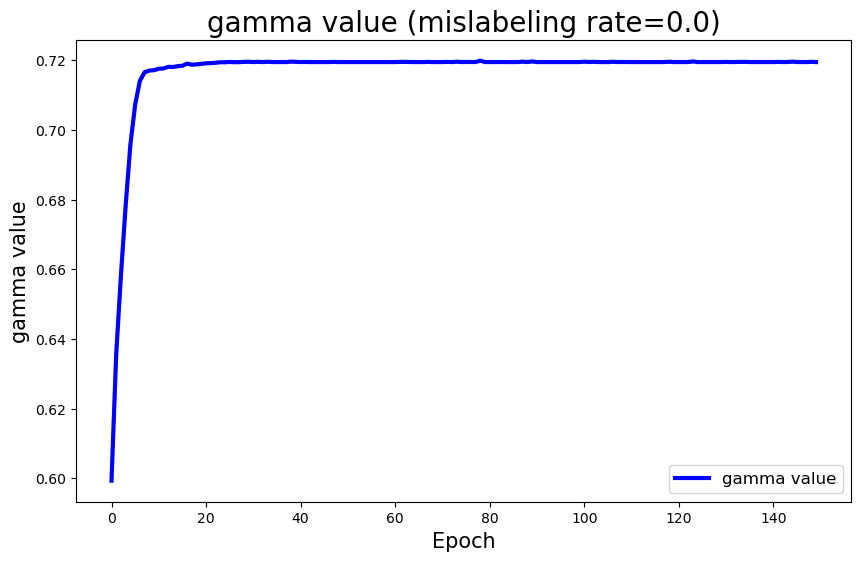

In [25]:
def plot_gamma_history(model_name, gamma_history,  num_epochs):
    
    x = np.arange(num_epochs)
    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, gamma_history, label='gamma value', lw=3, c="b")

    plt.title(f"{model_name}", fontsize=20)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("gamma value", fontsize=15)

    plt.show()
    

plot_gamma_history('gamma value (mislabeling rate=0.0)', gamma_history, len(gamma_history))#num_epochs

### Plot Dice score

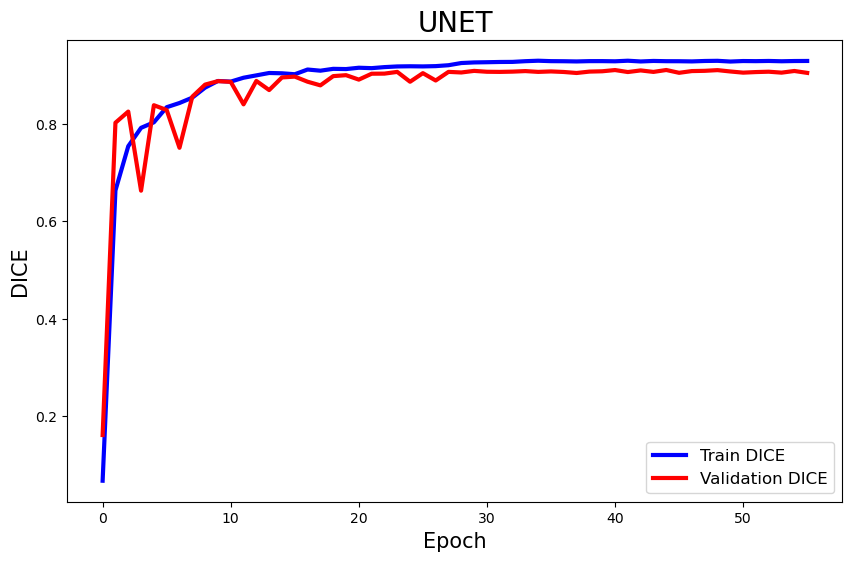

In [23]:
def plot_dice_history(model_name, train_dice_history, val_dice_history, num_epochs):
    
    x = np.arange(num_epochs)
    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_dice_history, label='Train DICE', lw=3, c="b")
    plt.plot(x, val_dice_history, label='Validation DICE', lw=3, c="r")

    plt.title(f"{model_name}", fontsize=20)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("DICE", fontsize=15)

    plt.show()
    
plot_dice_history('UNET', train_dice_history, val_dice_history, len(train_dice_history))#num_epochs

### Plot IOU

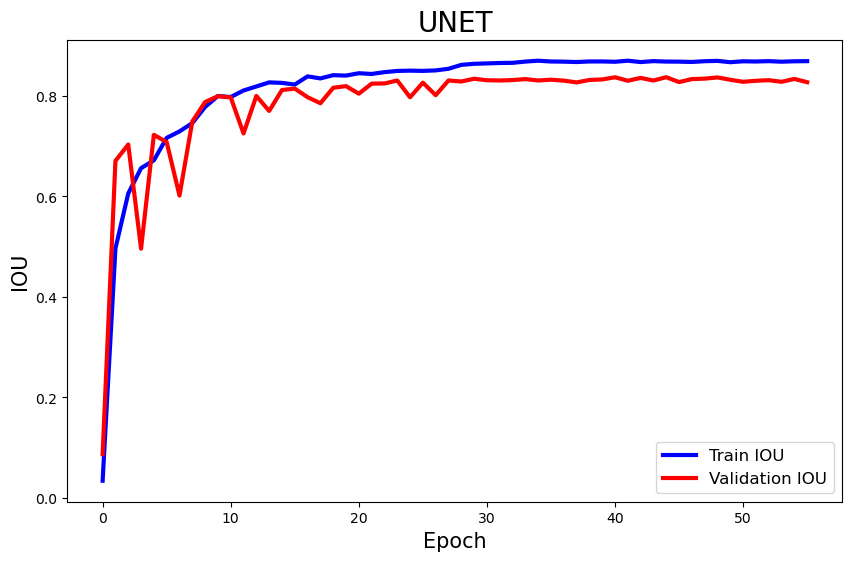

In [24]:
def plot_iou_history(model_name, train_iou_history, val_iou_history, num_epochs):
    
    x = np.arange(num_epochs)
    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_iou_history, label='Train IOU', lw=3, c="b")
    plt.plot(x, val_iou_history, label='Validation IOU', lw=3, c="r")

    plt.title(f"{model_name}", fontsize=20)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("IOU", fontsize=15)

    plt.show()
    
plot_iou_history('UNET', train_iou_history, val_iou_history, len(train_dice_history))

### Plot loss 

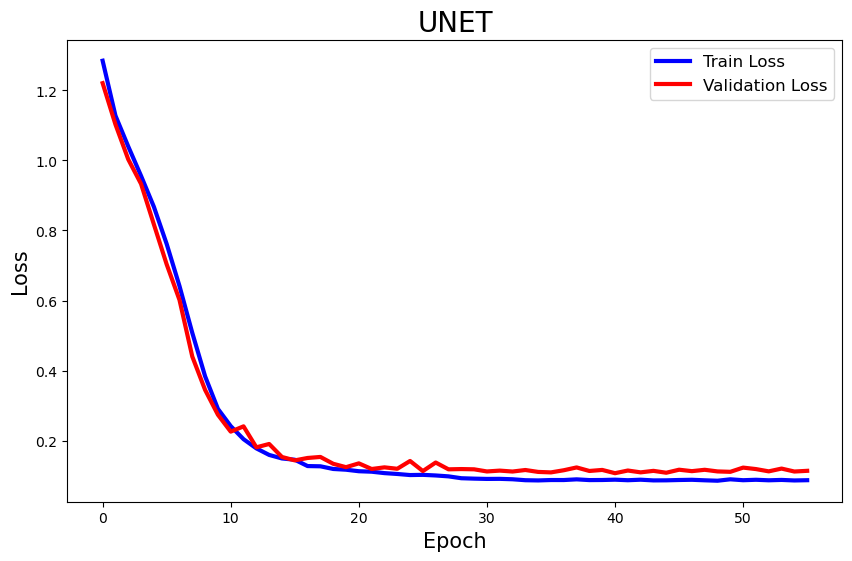

In [25]:
def plot_loss_history(model_name, train_loss_history, val_loss_history, num_epochs):
    
    x = np.arange(num_epochs)
    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_loss_history, label='Train Loss', lw=3, c="b")
    plt.plot(x, val_loss_history, label='Validation Loss', lw=3, c="r")

    plt.title(f"{model_name}", fontsize=20)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("Loss", fontsize=15)

    plt.show()
    
plot_loss_history('UNET', train_loss_history, val_loss_history, len(train_dice_history))

### Prediction on test

In [26]:
#%%time
#model = ResNeXtUNet(n_classes=1).to(device)
#model = UNet(3, 1).to(device)
#model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=3, out_channels=1, init_features=32, pretrained=False).to(device)
#model = Model().to(device)
'''
model = UTNet(in_chan=3, base_chan=16, num_classes=1, reduce_size=8,
              block_list='1234', num_blocks=[1,1,1,1], num_heads=[2,2,2,2],#4
              projection='interp', attn_drop=0.1, proj_drop=0.1, rel_pos=True, aux_loss=False, maxpool=True).to(device)
'''

model = efficientunet.get_efficientunet_b0(out_channels=1, concat_input=True, pretrained=True).to(device)

################################################
## LOAD Trained Model for Test Prediction
################################################
model.load_state_dict(torch.load(os.path.join('./model_results/', save_path)))
test_dice, test_iou, test_loss = eval_loop(model, test_dl, config['gamma'], config, run='test', training=False)
print("Mean DICE: {:.3f}%, Mean IOU: {:.3f}%, Loss: {:.3f}".format((100*test_dice),(100*test_iou), test_loss))

100% 7/7 [00:00<00:00,  7.27it/s]


Mean DICE: 89.555%, Mean IOU: 81.086%, Loss: 0.930


In [8]:
import numpy as np
slices = [1878, 1029, 640, 358]
wei = slices / np.sum(slices)

dice = np.array([0.478, 0.358, 0.490, 0.177])
iou = np.array([0.314, 0.218, 0.324, 0.097])

round(np.sum(dice*wei),3), round(np.sum(iou*wei),3)

(0.421, 0.27)

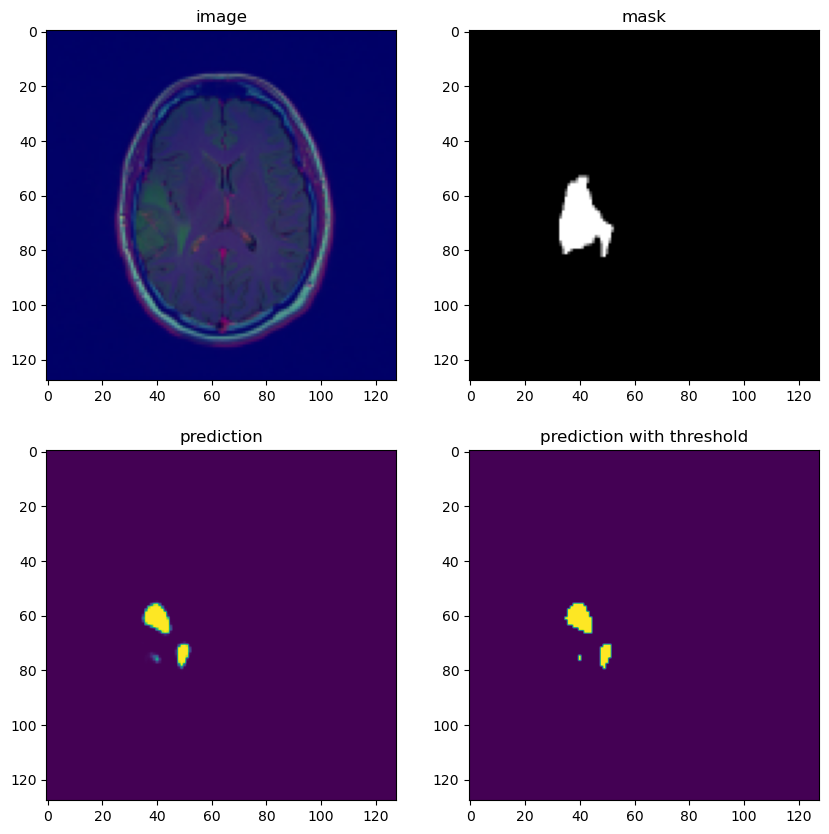

In [31]:
test_sample = test_df[test_df["diagnosis"] == 1].sample(24).values[0]
image = cv2.resize(cv2.imread(test_sample[0]), (128, 128))
mask = cv2.resize(cv2.imread(test_sample[1]), (128, 128))

# pred
pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(pred)
pred = model(pred.to(device))
pred = pred.detach().cpu().numpy()[0,0,:,:]

pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.3)] = 0.0
pred_t[np.nonzero(pred_t >= 0.3)] = 255.
pred_t = pred_t.astype("uint8")

# plot
fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")
ax[0, 1].imshow(mask)
ax[0, 1].set_title("mask")
ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")
ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")
plt.show()